# Исследование данных о продажах и оценках компьютерных играх с целью выявления закономерностях определяющих успешность игры
### Введение: 
Из открытых источников доступны исторические данные о продажах игр до 2016 года: оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation)
### Цель:
Необходимо выявить определяющие успешность игры закономерности для планирования рекламных кампаний на 2017 год.

## Изучение данных из файлов

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import median
from datetime import datetime
pd.set_option('display.max_columns', None)
import numpy as np
from scipy import stats as st

In [2]:
# чтение файла с данными и сохранение в df_init
path = 'input/'
df_init = pd.read_csv(path + 'prj_05_games.csv')

#### Таблица games:

In [3]:
df_init.head(3)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E


###### Описание данных games
* `Name` — название игры
* `Platform` — платформа
* `Year_of_Release` — год выпуска
* `Genre` — жанр игры
* `NA_sales` — продажи в Северной Америке (миллионы проданных копий)
* `EU_sales` — продажи в Европе (миллионы проданных копий)
* `JP_sales` — продажи в Японии (миллионы проданных копий)
* `Other_sales` — продажи в других странах (миллионы проданных копий)
* `Critic_Score` — оценка критиков (максимум 100)
* `User_Score` — оценка пользователей (максимум 10)
* `Rating` — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

In [4]:
# получение общей информации о данных в таблице
df_init.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [5]:
# пропущенные значения бары
def pass_value(df):
    (
        (df.isna().mean()*100)
        .to_frame()
        .rename(columns = {0:'space'})
        .query('space >= 0')
        .sort_values(by = 'space', ascending = True)
        .plot(kind= 'barh', figsize=(10,6), rot = 0, legend = False, fontsize = 16)
        .set_title('Missing data, %' + "\n", fontsize = 15, color = 'SteelBlue')    
    ); 

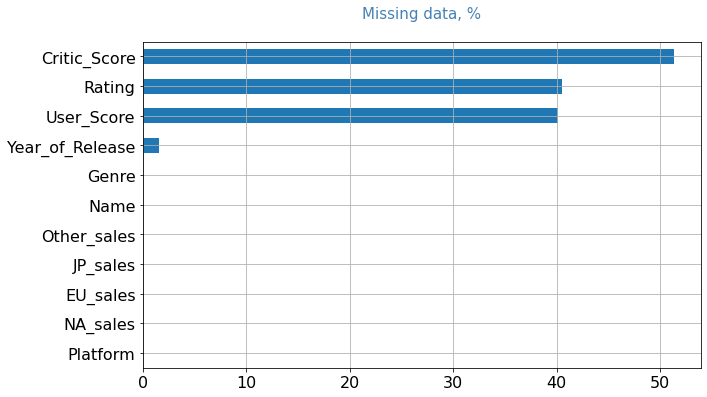

In [6]:
pass_value(df_init)
plt.grid()

### Вывод

##### Таблица games: 
В таблице представлено 16715 строк. 
В каждой строке - данные о игре. 

В первых 4х колонках предствлены название, платформа, год выхода и жанр игры.
Следующие 4 колонки описывают продажи в различных регионах. 

В 2х колонках представлена оценка игы критиками и пользователями. 
В последней колонке представлена возрастная категория игры 

Предварительно можно утверждать, что, данных достаточно для составления гипотиз. Но встречаются пропуски в данных, а в названиях колонок — расхождения с хорошим стилем.

Необходимо проверить данные на дубликаты (явные и не явные), проанализировать пропуски и привести заголовки к одному стилю.

## Предобработка данных

In [7]:
# Создадим копию исходной таблицы и будем с ней работать
df = df_init.copy()

In [8]:
# Список названий колонок
column_list = list(df.columns)
column_list

['Name',
 'Platform',
 'Year_of_Release',
 'Genre',
 'NA_sales',
 'EU_sales',
 'JP_sales',
 'Other_sales',
 'Critic_Score',
 'User_Score',
 'Rating']

In [9]:
#Переведем все символы в заголовках к строчному типу
df.columns = df.columns.str.lower()

In [10]:
# Проверим названия заголовков после изменения
df.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

In [11]:
# Функция для анализа данных в колонках
def data_analysis(column_name):
    print()
    print('-'*40)
    print(f'Анализ данных в колонке {column_name}')
    print('-'*40)
    print(f'Тип данных в колонке: {df[column_name].dtype}')
    data_0 = len(df[df[column_name].isnull()==True])
    print(f'Количество отсутствующих значений в столбце: {data_0}')
    print(f'Процент отсутствующих значений: {data_0/len(df):.2%}')
    print(f'Число уникальных данных: {len(df[column_name].unique())}')
    if len(df[column_name].unique()) < 40:
        print(f'Уникальные значения: {df[column_name].unique()}')
    else:
        print('Число уникальных значений слишком велико для вывода')
    print('Описание данных в колонке:')
    display(df[column_name].describe()) 

In [12]:
# Изучим данные в колонке 'name'
data_analysis('name')


----------------------------------------
Анализ данных в колонке name
----------------------------------------
Тип данных в колонке: object
Количество отсутствующих значений в столбце: 2
Процент отсутствующих значений: 0.01%
Число уникальных данных: 11560
Число уникальных значений слишком велико для вывода
Описание данных в колонке:


count                           16713
unique                          11559
top       Need for Speed: Most Wanted
freq                               12
Name: name, dtype: object

In [13]:
# Посмотрим строки, где отсутствуют данные
df.query('name.isna()')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


В этих строках отсутствуют данные по оценкам и жанру. Исключим эти строки из таблицы

In [14]:
# Таблица без пропущеных значений в колонке name
df = df.query('name.notna()')
df.reset_index(drop=True, inplace=True)

In [15]:
# получение общей информации о данных в таблице
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16713 entries, 0 to 16712
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16444 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [16]:
# проверка на отсутствие дубликатов
df.duplicated().sum()

0

In [17]:
# Изучим данные в колонке 'name'
data_analysis('name')


----------------------------------------
Анализ данных в колонке name
----------------------------------------
Тип данных в колонке: object
Количество отсутствующих значений в столбце: 0
Процент отсутствующих значений: 0.00%
Число уникальных данных: 11559
Число уникальных значений слишком велико для вывода
Описание данных в колонке:


count                           16713
unique                          11559
top       Need for Speed: Most Wanted
freq                               12
Name: name, dtype: object

##### Колонка name. Выводы:
В колонке name больше нет пропусков. В таблице осталось 16713 записи.
В названиях игр имеется 11559 уникальных значений. 

In [18]:
# Изучим данные в колонке 'platform'
data_analysis('platform')


----------------------------------------
Анализ данных в колонке platform
----------------------------------------
Тип данных в колонке: object
Количество отсутствующих значений в столбце: 0
Процент отсутствующих значений: 0.00%
Число уникальных данных: 31
Уникальные значения: ['Wii' 'NES' 'GB' 'DS' 'X360' 'PS3' 'PS2' 'SNES' 'GBA' 'PS4' '3DS' 'N64'
 'PS' 'XB' 'PC' '2600' 'PSP' 'XOne' 'WiiU' 'GC' 'GEN' 'DC' 'PSV' 'SAT'
 'SCD' 'WS' 'NG' 'TG16' '3DO' 'GG' 'PCFX']
Описание данных в колонке:


count     16713
unique       31
top         PS2
freq       2161
Name: platform, dtype: object

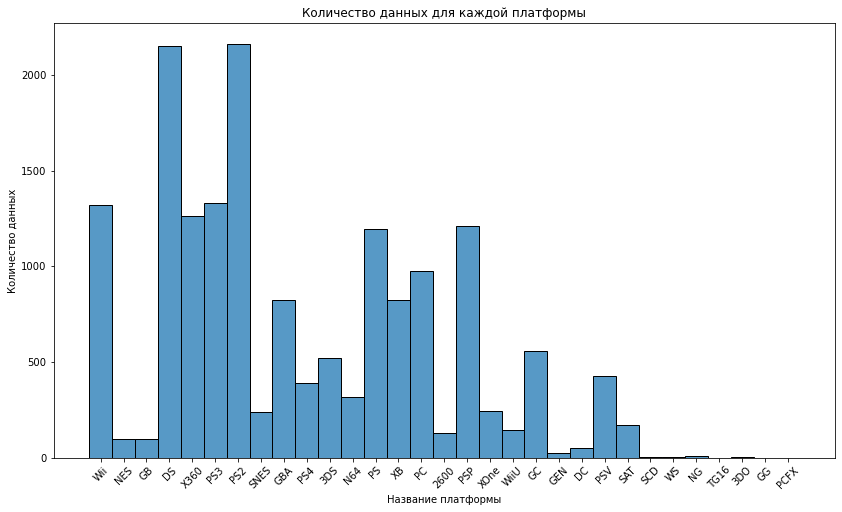

In [20]:
# Построим гистограмму
plt.figure(figsize=(14,8))
sns.histplot(df['platform'], bins=31)
plt.xticks(rotation=45)
plt.xlabel('Название платформы')
plt.ylabel('Количество данных')
plt.title('Количество данных для каждой платформы')
plt.show()

In [21]:
# Посмотрим количество данных для каждой платформы
df.pivot_table(index='platform', values='name', aggfunc='count').sort_values(by='name',ascending=False)

,name
platform,
PS2,2161
DS,2151
PS3,1331
Wii,1320
X360,1262
PSP,1209
PS,1197
PC,974
XB,824


##### Колонка platform. Выводы:
В колонке platform нет пропусков. Имеется 31 уникальных платформ. В таблице имеется больше всего данных для двух платформ PS2 и DS (около 2200 записпей). Всего по одной записи имеется для платформы PCFX и GG

In [22]:
# Изучим данные в колонке 'year_of_release'
data_analysis('year_of_release')


----------------------------------------
Анализ данных в колонке year_of_release
----------------------------------------
Тип данных в колонке: float64
Количество отсутствующих значений в столбце: 269
Процент отсутствующих значений: 1.61%
Число уникальных данных: 38
Уникальные значения: [2006. 1985. 2008. 2009. 1996. 1989. 1984. 2005. 1999. 2007. 2010. 2013.
 2004. 1990. 1988. 2002. 2001. 2011. 1998. 2015. 2012. 2014. 1992. 1997.
 1993. 1994. 1982. 2016. 2003. 1986. 2000.   nan 1995. 1991. 1981. 1987.
 1980. 1983.]
Описание данных в колонке:


count    16444.000000
mean      2006.486256
std          5.875525
min       1980.000000
25%       2003.000000
50%       2007.000000
75%       2010.000000
max       2016.000000
Name: year_of_release, dtype: float64

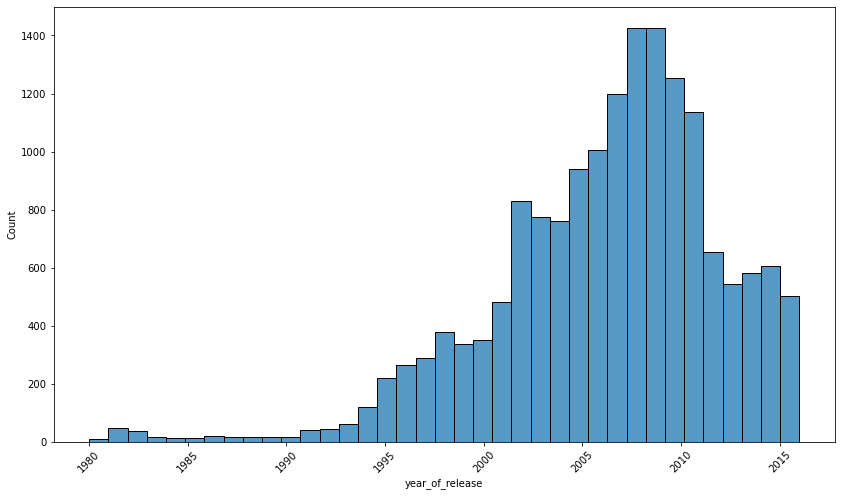

In [23]:
# Построим гистограмму
plt.figure(figsize=(14,8))
sns.histplot(df['year_of_release'], bins=37)
plt.xticks(rotation=45)
plt.show()

In [24]:
# Посмотрим количество данных для каждого года выпуска игры
df.pivot_table(index='year_of_release', values='name', aggfunc='count').sort_values(by='name',ascending=False) 

,name
year_of_release,
2008.0,1427
2009.0,1426
2010.0,1255
2007.0,1197
2011.0,1136
2006.0,1006
2005.0,939
2002.0,829
2003.0,775


Для заполнения отсутствующих данных в колонке year_of_release, создадим отдельную таблицу,где нет данных по году выпуску игры. 

In [25]:
# таблица, где нет данных по году выпуска игры
df_y_na = df.query('year_of_release.isna()')

In [26]:
# Посмотрим список уникальных названий игр в таблице, где отсутствует год выпуска игры
list(df_y_na['name'].unique())

['Madden NFL 2004',
 'FIFA Soccer 2004',
 'LEGO Batman: The Videogame',
 'wwe Smackdown vs. Raw 2006',
 'Space Invaders',
 'Rock Band',
 "Frogger's Adventures: Temple of the Frog",
 'LEGO Indiana Jones: The Original Adventures',
 'Call of Duty 3',
 'Call of Duty: Black Ops',
 'Triple Play 99',
 'Adventure',
 'Combat',
 'LEGO Harry Potter: Years 5-7',
 'NASCAR Thunder 2003',
 'Hitman 2: Silent Assassin',
 'Legacy of Kain: Soul Reaver',
 'Donkey Kong Land III',
 'Air-Sea Battle',
 'Suikoden III',
 'Wheel of Fortune',
 'Yakuza 4',
 'Namco Museum',
 'Rhythm Heaven',
 'The Lord of the Rings: War in the North',
 'Madden NFL 07',
 'MLB SlugFest 20-03',
 'Shaun White Snowboarding',
 'PES 2009: Pro Evolution Soccer',
 'WarioWare: Twisted!',
 'Madden NFL 11',
 'Test Drive Unlimited 2',
 'The Chronicles of Narnia: The Lion, The Witch and The Wardrobe',
 'Monster Hunter 2',
 'Metal Gear Solid 2: Substance',
 'Advance Wars: Days of Ruin',
 'The Golden Compass',
 'Madden NFL 06',
 'NASCAR: Dirt to D

Видно, что в названии многих игр присутствует год выпуска. Создадим дополнительную колонку, куда запишем год выпуска из названия

In [27]:
def year_in_name(row):
    list_x = row.split()
    for i in list_x:
        if i.isnumeric():
            if len(i)==4:
                year_release = i
            elif len(i)==2:
                if i[0]=="0":
                    i = '20'+ i
                    year_release = i
        else:
            year_release = 0
    return year_release  

In [28]:
# Создадим колонку в таблице df_y_na с годом выпуска из названия игры
df_y_na['year_release_name'] = df_y_na['name'].apply(year_in_name)

C:\Users\Anna\AppData\Local\Temp/ipykernel_23068/2534084171.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_y_na['year_release_name'] = df_y_na['name'].apply(year_in_name)


In [29]:
df_y_na.head(5)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,year_release_name
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E,2004
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E,2004
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+,0
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN,2006
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN,0


In [30]:
# Создадим отдельный датасет для найденых годов выхода игры
df_year_found = df_y_na.query('year_release_name !=0')
df_year_found

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,year_release_name
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E,2004
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E,2004
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN,2006
1649,NASCAR Thunder 2003,PS2,NaN,Racing,0.60,0.46,0.00,0.16,84.0,8.7,E,2003
2478,Madden NFL 07,PSP,NaN,Sports,0.77,0.03,0.00,0.04,78.0,6.6,E,2007
3412,Madden NFL 06,X360,NaN,Sports,0.54,0.00,0.01,0.03,74.0,4.9,E,2006
3485,Madden NFL 2002,XB,NaN,Sports,0.53,0.02,0.00,0.03,90.0,8.1,E,2002
4204,Tiger Woods PGA Tour 07,Wii,NaN,Sports,0.43,0.00,0.00,0.04,71.0,6.9,E,2007
4774,NFL GameDay 2003,PS2,NaN,Sports,0.20,0.15,0.00,0.05,60.0,tbd,E,2003
5155,NBA Live 2003,XB,NaN,Sports,0.31,0.04,0.00,0.01,82.0,8.8,E,2003


In [31]:
# Вставим полученые значения года выпуска в колонку year_of_release общей таблицы df
for index, row in df_year_found.iterrows():
    df.at[index, 'year_of_release'] = df_year_found.at[index, 'year_release_name']

In [32]:
# Изучим данные в колонке 'year_of_release' после вставки найденых значений
data_analysis('year_of_release')


----------------------------------------
Анализ данных в колонке year_of_release
----------------------------------------
Тип данных в колонке: object
Количество отсутствующих значений в столбце: 251
Процент отсутствующих значений: 1.50%
Число уникальных данных: 46
Число уникальных значений слишком велико для вывода
Описание данных в колонке:


count     16462.0
unique       45.0
top        2008.0
freq       1427.0
Name: year_of_release, dtype: float64

In [33]:
# Еще раз создадим таблицу, где нет данных по году выпуска игры
df_y_na2 = df.query('year_of_release.isna()')

In [34]:
df_y_na2.head(5)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.0,0.29,74.0,7.9,E10+
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.0,0.03,NaN,NaN,NaN
627,Rock Band,X360,NaN,Misc,1.93,0.33,0.0,0.21,92.0,8.2,T
657,Frogger's Adventures: Temple of the Frog,GBA,NaN,Adventure,2.15,0.18,0.0,0.07,73.0,tbd,E
677,LEGO Indiana Jones: The Original Adventures,Wii,NaN,Action,1.51,0.61,0.0,0.21,78.0,6.6,E10+


Мы знаем, что в таблице df дублируются названия игр. Проверим, нет ли в общей таблице данных о годе выпуска для игр, указанных в таблице df_y_na2 

In [35]:
# Создадим отдельную таблицу, где есть данных по году выпуска игры
df_y_notna = df.query('year_of_release.notna()')

In [36]:
# Проверим есть ли год выпуска в таблице "df_y_notna" для игр, указанных в таблице "df_y_na2"
# Создадим списки для кол-ва уникальных значений годов выпуска : nb_unique
# Создадим список уникальных значений годов: year_list
# Создадим список с годом выпуска, если кол-во уникальных годов выпска равно 1: year_unq
nb_unique = []
year_list = []
year_unq = []
for index, row in df_y_na2.iterrows():
    name_i = df_y_na2.at[index, 'name']
    y_list_i = list(df_y_notna[df_y_notna['name'] == name_i]['year_of_release'].unique())
    nb_i = len(y_list_i)
    if nb_i == 1:
        year_unq.append(y_list_i[0])
    else:
        year_unq.append(0)
    nb_unique.append(nb_i)
    year_list.append(y_list_i)

In [37]:
# Добавим колонку в таблицу df_y_na2 с кол-ом уникальных годов выпуска
df_y_na2['nb_years'] = nb_unique

C:\Users\Anna\AppData\Local\Temp/ipykernel_23068/3919021104.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_y_na2['nb_years'] = nb_unique


In [38]:
# Добавим колонку в таблицу df_y_na2 со списком уникальных годов выпуска
df_y_na2['list_years'] = year_list

C:\Users\Anna\AppData\Local\Temp/ipykernel_23068/3732058968.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_y_na2['list_years'] = year_list


In [39]:
# Добавим колонку в таблицу df_y_na2 с годом выпуска из списка year_unq
df_y_na2['year_release_dup'] = year_unq

C:\Users\Anna\AppData\Local\Temp/ipykernel_23068/3674336308.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_y_na2['year_release_dup'] = year_unq


In [40]:
df_y_na2.head(3)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,nb_years,list_years,year_release_dup
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.0,0.29,74.0,7.9,E10+,1,[2008.0],2008.0
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.0,0.03,NaN,NaN,NaN,3,"[1994.0, 1999.0, 2002.0]",0.0
627,Rock Band,X360,NaN,Misc,1.93,0.33,0.0,0.21,92.0,8.2,T,0,[],0.0


In [41]:
# Вставим полученые значения года выпуска в колонку year_of_release общей таблицы df
for index, row in df_y_na2.iterrows():
    if df_y_na2.at[index, 'year_release_dup'] != 0:
        df.at[index, 'year_of_release'] = df_y_na2.at[index, 'year_release_dup']

In [42]:
# Изучим данные в колонке 'year_of_release' после вставки найденых значений
data_analysis('year_of_release')


----------------------------------------
Анализ данных в колонке year_of_release
----------------------------------------
Тип данных в колонке: object
Количество отсутствующих значений в столбце: 151
Процент отсутствующих значений: 0.90%
Число уникальных данных: 46
Число уникальных значений слишком велико для вывода
Описание данных в колонке:


count     16562.0
unique       45.0
top        2008.0
freq       1438.0
Name: year_of_release, dtype: float64

В таблице осталось 151 записи без года выпуска игры. Это 0,9% от всех записей. Удалим эти строки. И преобразуем тип данных в int

In [43]:
df = df.query('year_of_release.notna()')

In [44]:
# Изменим тип данных в колонке year_of_release на int
df['year_of_release'] = df['year_of_release'].astype('int')

C:\Users\Anna\AppData\Local\Temp/ipykernel_23068/2912049820.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year_of_release'] = df['year_of_release'].astype('int')


In [45]:
# Изучим данные в колонке 'year_of_release' после вставки найденых значений
data_analysis('year_of_release')


----------------------------------------
Анализ данных в колонке year_of_release
----------------------------------------
Тип данных в колонке: int32
Количество отсутствующих значений в столбце: 0
Процент отсутствующих значений: 0.00%
Число уникальных данных: 37
Уникальные значения: [2006 1985 2008 2009 1996 1989 1984 2005 1999 2007 2010 2013 2004 1990
 1988 2002 2001 2011 1998 2015 2012 2014 1992 1997 1993 1994 1982 2016
 2003 1986 2000 1995 1991 1981 1987 1980 1983]
Описание данных в колонке:


count    16562.000000
mean      2006.492694
std          5.862151
min       1980.000000
25%       2003.000000
50%       2007.000000
75%       2010.000000
max       2016.000000
Name: year_of_release, dtype: float64

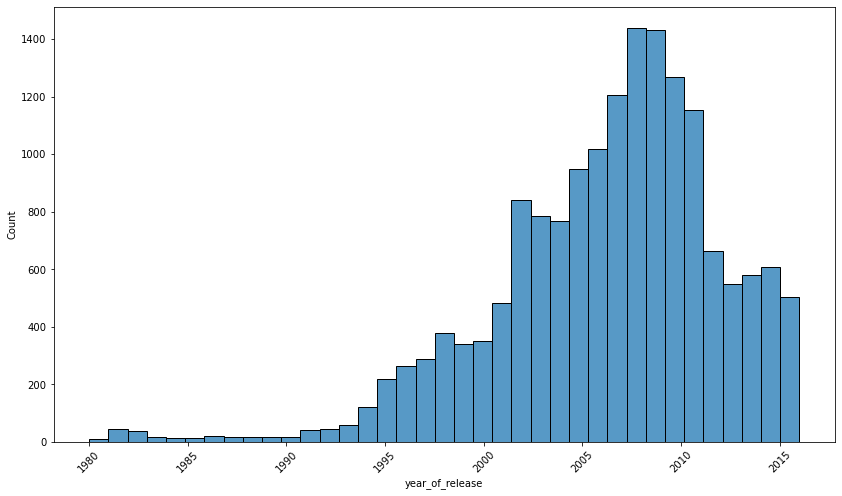

In [46]:
# Построим гистограмму после преобразований
plt.figure(figsize=(14,8))
sns.histplot(df['year_of_release'], bins=37)
plt.xticks(rotation=45)
plt.show()

##### Колонка year_of_release. Выводы:
В таблице больше нет пропусков по году выпуска. Все данные преобразованны в целочисленный тип данных. 
Самый ранний год издания - 1980. Самый поздний  - 2016. Большая часть игр в таблице была издана после 2003 года. 

In [47]:
# Изучим данные в колонке 'genre'
data_analysis('genre')


----------------------------------------
Анализ данных в колонке genre
----------------------------------------
Тип данных в колонке: object
Количество отсутствующих значений в столбце: 0
Процент отсутствующих значений: 0.00%
Число уникальных данных: 12
Уникальные значения: ['Sports' 'Platform' 'Racing' 'Role-Playing' 'Puzzle' 'Misc' 'Shooter'
 'Simulation' 'Action' 'Fighting' 'Adventure' 'Strategy']
Описание данных в колонке:


count      16562
unique        12
top       Action
freq        3340
Name: genre, dtype: object

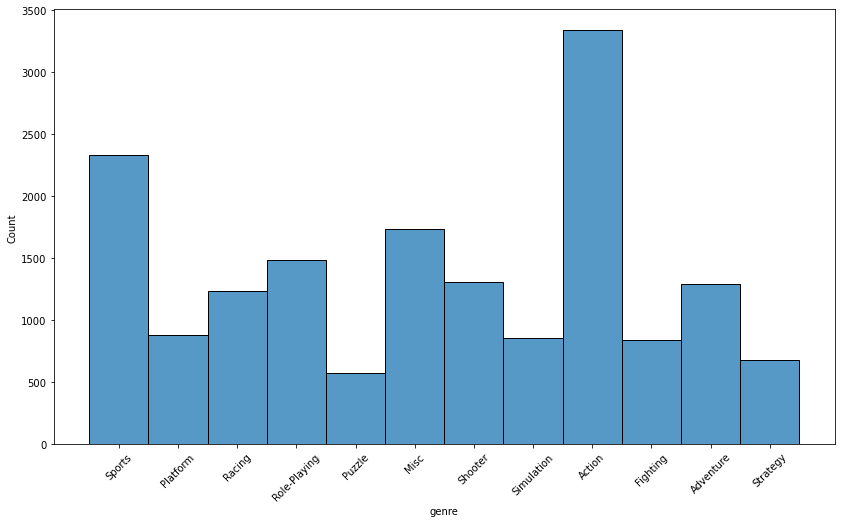

In [48]:
# Построим гистограмму для данных в колонке genre
plt.figure(figsize=(14,8))
sns.histplot(df['genre'], bins=37)
plt.xticks(rotation=45)
plt.show()

In [49]:
# Посмотрим количество данных для каждого жанра игры
df_genre = df.pivot_table(index='genre', values='name', aggfunc='count').sort_values(by='name',ascending=False)
df_genre = df_genre.reset_index()
df_genre

,genre,name
0,Action,3340
1,Sports,2334
2,Misc,1733
3,Role-Playing,1484
4,Shooter,1310
5,Adventure,1294
6,Racing,1236
7,Platform,878
8,Simulation,860
9,Fighting,842


##### Колонка genre. Выводы:
В колонке genre нет пропусков. Тип данных - object. Самый популярный жанр игры в таблице- Action. Меньше всего записей в таблице представлено для жанра Puzzle. 

In [50]:
# посмотрим описание таблицы после изменений
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16562 entries, 0 to 16712
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16562 non-null  object 
 1   platform         16562 non-null  object 
 2   year_of_release  16562 non-null  int32  
 3   genre            16562 non-null  object 
 4   na_sales         16562 non-null  float64
 5   eu_sales         16562 non-null  float64
 6   jp_sales         16562 non-null  float64
 7   other_sales      16562 non-null  float64
 8   critic_score     8072 non-null   float64
 9   user_score       9930 non-null   object 
 10  rating           9863 non-null   object 
dtypes: float64(5), int32(1), object(5)
memory usage: 1.5+ MB


Видно, что 4х колонках, посвященных продажам, нет пропусков. Проверим данныхе на аномальные значения. Сравним продажи по каждому жанку в 4х регионах

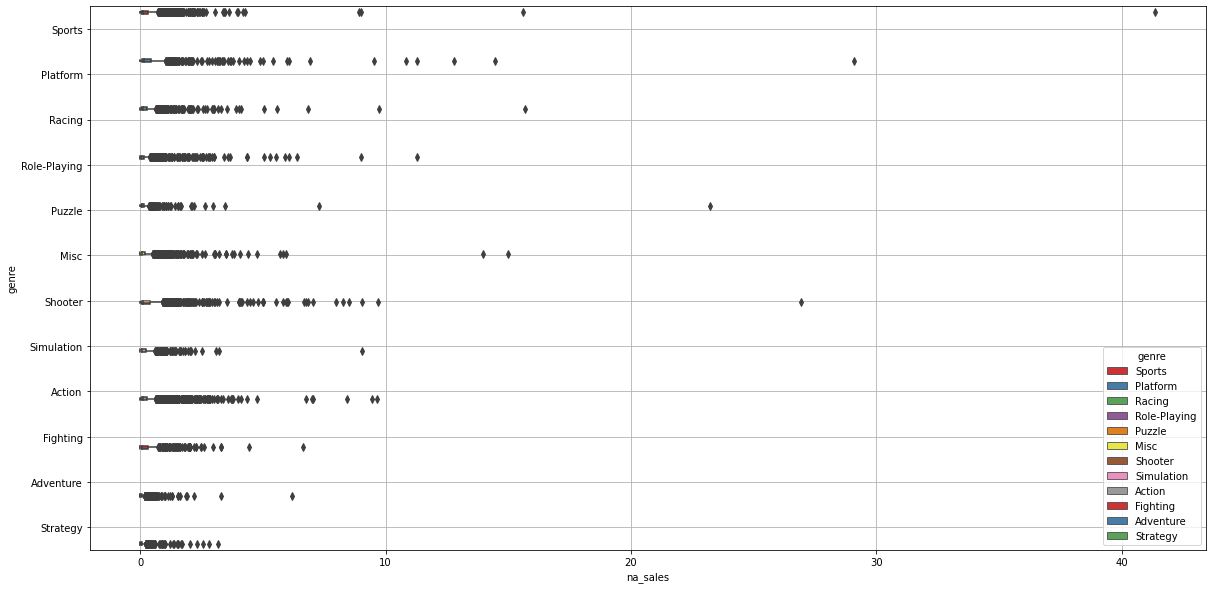

In [51]:
# Посмотрим кол-во продаж по каждому жанку в колонке 'na_sales'
plt.figure(figsize=(20,10))
sns.boxplot(data=df, x='na_sales', y = 'genre', hue='genre', palette="Set1");
plt.grid()
plt.show();

In [52]:
# Максимальное кол-во продаж в колонке na_sales
df['na_sales'].max()

41.36

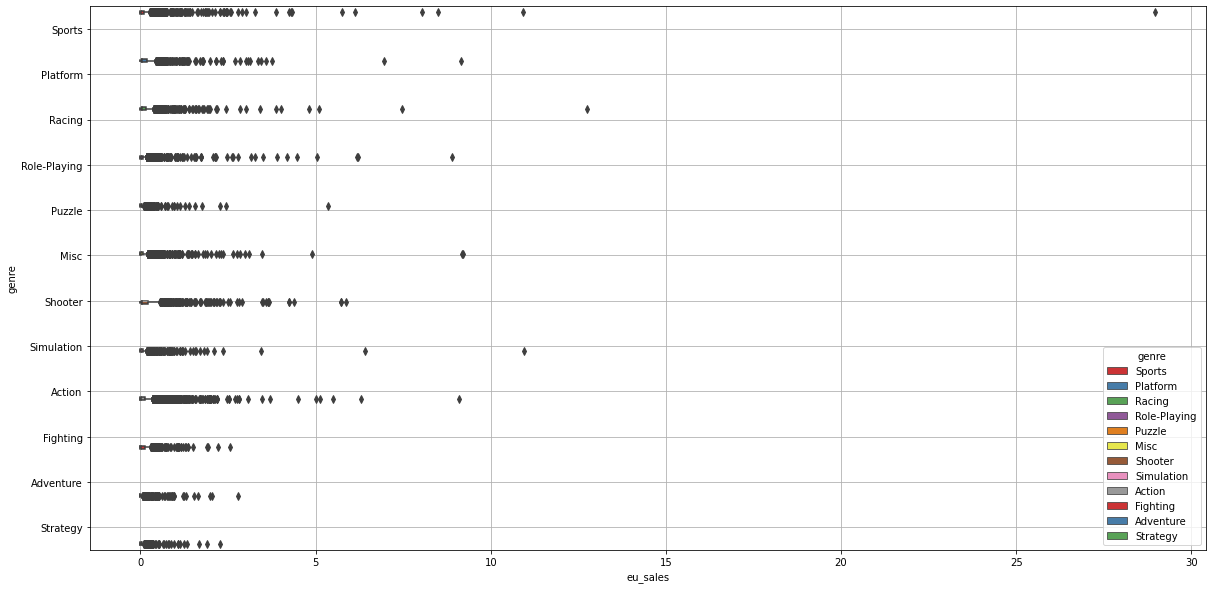

In [53]:
# Посмотрим кол-во продаж по каждому жанку в колонке 'eu_sales'
plt.figure(figsize=(20,10))
sns.boxplot(data=df, x='eu_sales', y = 'genre', hue='genre', palette="Set1");
plt.grid()
plt.show();

In [54]:
# Максимальное кол-во продаж в колонке eu_sales
df['eu_sales'].max()

28.96

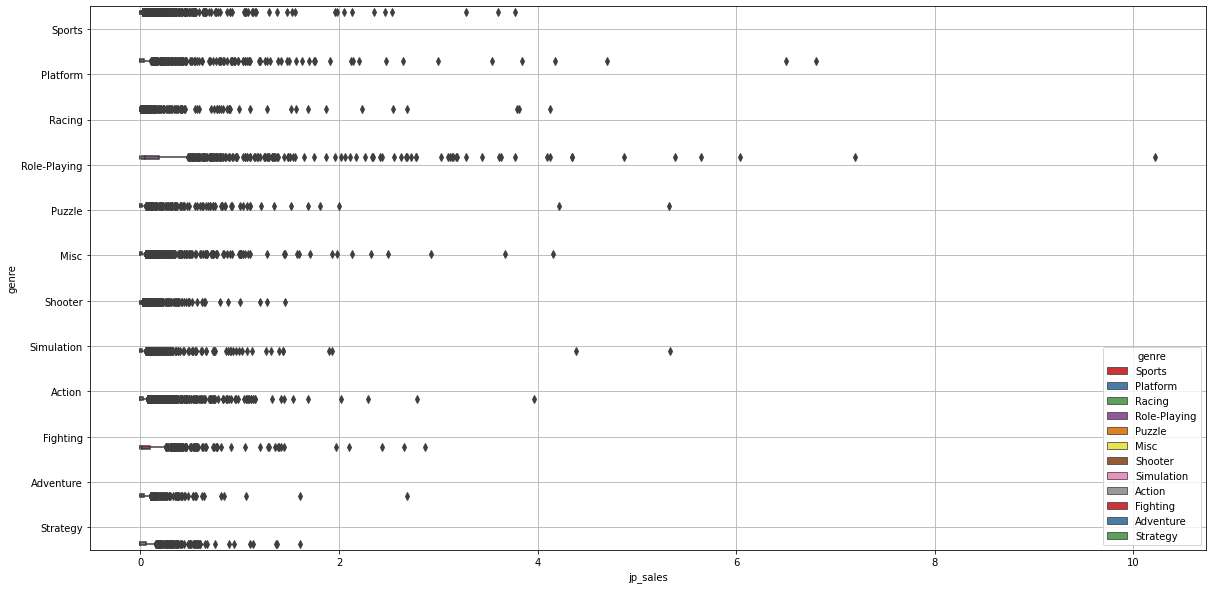

In [55]:
# Посмотрим кол-во продаж по каждому жанку в колонке 'jp_sales'
plt.figure(figsize=(20,10))
sns.boxplot(data=df, x='jp_sales', y = 'genre', hue='genre', palette="Set1");
plt.grid()
plt.show();

In [56]:
# Максимальное кол-во продаж в колонке jp_sales
df['jp_sales'].max()

10.22

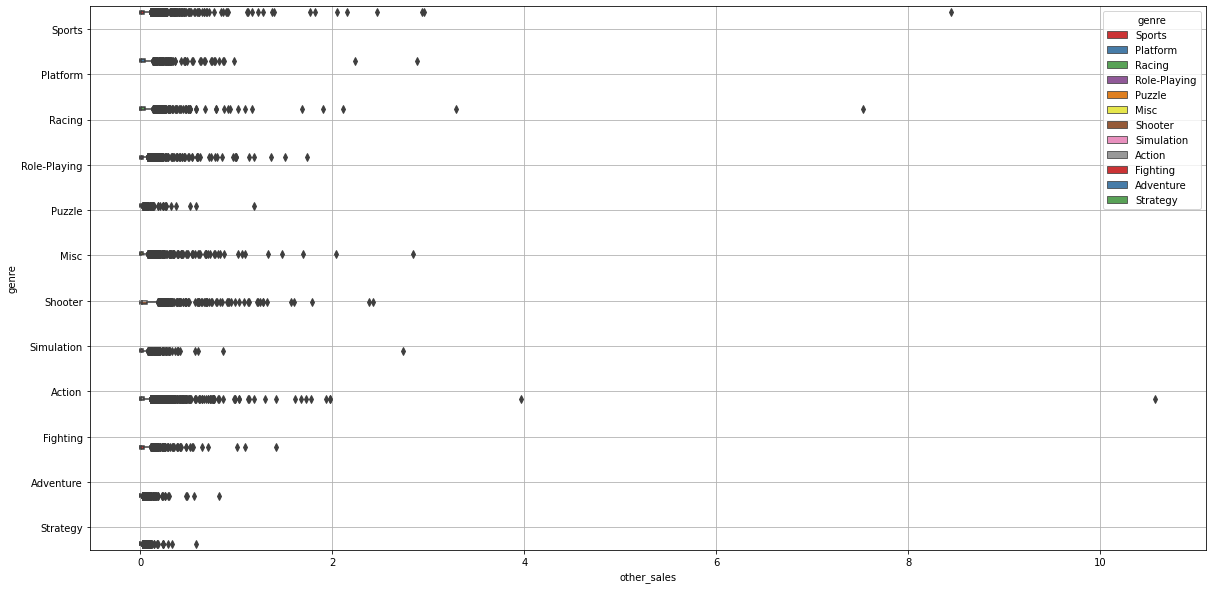

In [57]:
# Посмотрим кол-во продаж по каждому жанку в колонке 'other_sales'
plt.figure(figsize=(20,10))
sns.boxplot(data=df, x='other_sales', y = 'genre', hue='genre', palette="Set1");
plt.grid()
plt.show();

In [58]:
# Максимальное кол-во продаж в колонке other_sales
df['other_sales'].max()

10.57

Вывод: по каждому региону большой разброс данных кол-ва проданных копий. Максимальное кол-во продаж в Северной Америке - 41 млн.копий. Аномальных значений в колонках по продажам нет. Создадим одну колонку с кол-вом продаж по всем регионам.

In [59]:
df['sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16562 entries, 0 to 16712
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16562 non-null  object 
 1   platform         16562 non-null  object 
 2   year_of_release  16562 non-null  int32  
 3   genre            16562 non-null  object 
 4   na_sales         16562 non-null  float64
 5   eu_sales         16562 non-null  float64
 6   jp_sales         16562 non-null  float64
 7   other_sales      16562 non-null  float64
 8   critic_score     8072 non-null   float64
 9   user_score       9930 non-null   object 
 10  rating           9863 non-null   object 
 11  sales            16562 non-null  float64
dtypes: float64(6), int32(1), object(5)
memory usage: 1.6+ MB


In [61]:
# Изучим данные в колонке 'sales'
data_analysis('sales')


----------------------------------------
Анализ данных в колонке sales
----------------------------------------
Тип данных в колонке: float64
Количество отсутствующих значений в столбце: 0
Процент отсутствующих значений: 0.00%
Число уникальных данных: 1006
Число уникальных значений слишком велико для вывода
Описание данных в колонке:


count    16562.000000
mean         0.535316
std          1.554538
min          0.000000
25%          0.060000
50%          0.170000
75%          0.470000
max         82.540000
Name: sales, dtype: float64

Проверим сколько данных в таблице с кол-ом продаж равным 0

In [62]:
df.query('sales==0')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales
16674,G1 Jockey 4 2008,PS3,2008,Sports,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0
16707,SCORE International Baja 1000: The Official Game,PS2,2008,Racing,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0


Исключим из таблицы строки с кол-ом продаж, равным 0

In [63]:
df = df.query('sales != 0')

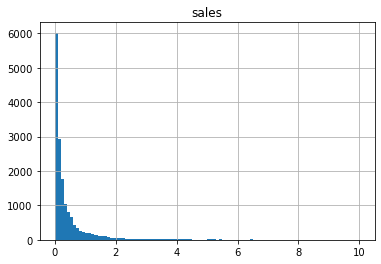

In [64]:
# Построим гистограмму
df['sales'].hist(bins=100, range=(0,10));
plt.title('sales');

##### Колонка sales. Выводы:
Большая часть игр в таблице имеют кол-во продаж до 500 тыс. копий. Максимальное кол-во продаж - 82,5 млн. копий.

In [65]:
# Изучим данные в колонке 'rating'
data_analysis('rating')


----------------------------------------
Анализ данных в колонке rating
----------------------------------------
Тип данных в колонке: object
Количество отсутствующих значений в столбце: 6697
Процент отсутствующих значений: 40.44%
Число уникальных данных: 9
Уникальные значения: ['E' nan 'M' 'T' 'E10+' 'K-A' 'AO' 'EC' 'RP']
Описание данных в колонке:


count     9863
unique       8
top          E
freq      3957
Name: rating, dtype: object

Описание категорий:

* `EC` - Titles rated EC (Early Childhood) have content that may be suitable for ages 3 and older. Contains no material that parents would find inappropriate.
* `E` - Titles rated E (Everyone) have content that is generally suitable for all ages. May contain minimal cartoon, fantasy or mild violence and/or infrequent use of mild language.
* `E10+` - Titles rated E10+ (Everyone 10 and older) have content that is generally suitable for ages 10 and up. May contain more cartoon, fantasy or mild violence, mild language and/or minimal suggestive themes.themes.
* `T` - Titles rated T (Teen) have content that is generally suitable for ages 13 and up. May contain violence, suggestive themes, crude humor, minimal blood, simulated gambling, and/or infrequent use of strong language.
* `M` - Titles rated M (Mature) have content that is generally suitable for persons ages 17 and up. May contain intense violence, blood and gore, sexual content and/or strong language.
* `AO` - Titles rated AO (Adults Only) have content that is only suitable for persons ages 17 and up. May contain intense violence, blood and gore, sexual content and/or strong language.
* `RP` - Titles listed as RP (Rating Pending) have not yet been assigned a final ESRB rating. (This symbol appears only in advertising and promotional materials prior to a game's release, and will be replaced by a game’s rating once it has been assigned.)
* `K-A` - This rating was initially known as Kids to Adults (K-A) until 1998. Since 1998 this category has been called E. 

In [66]:
# Переименуем 'K-A' как 'E'
df['rating'] = df['rating'].apply(lambda x: 'E' if x == 'K-A' else x)

In [67]:
# Изучим данные в колонке 'rating' после обновления
data_analysis('rating')


----------------------------------------
Анализ данных в колонке rating
----------------------------------------
Тип данных в колонке: object
Количество отсутствующих значений в столбце: 6697
Процент отсутствующих значений: 40.44%
Число уникальных данных: 8
Уникальные значения: ['E' nan 'M' 'T' 'E10+' 'AO' 'EC' 'RP']
Описание данных в колонке:


count     9863
unique       7
top          E
freq      3960
Name: rating, dtype: object

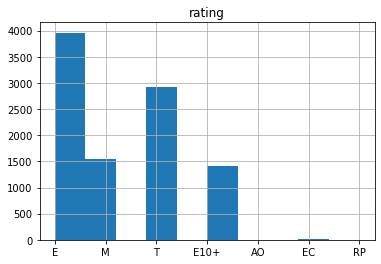

In [68]:
# Построим гистограмму
df['rating'].hist();
plt.title('rating');

In [69]:
# Создадим таблицу с кол-ом записей (игр) в зависимости от возрастной категории и жанра игры
df_pt_rat = df.pivot_table(index='genre', columns='rating' ,values='name', aggfunc='count').T
df_pt_rat.fillna(0,inplace=True)
df_pt_rat

genre,Action,Adventure,Fighting,Misc,Platform,Puzzle,Racing,Role-Playing,Shooter,Simulation,Sports,Strategy
rating,,,,,,,,,,,,
AO,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E,414.0,159.0,8.0,452.0,354.0,288.0,580.0,83.0,47.0,321.0,1182.0,72.0
E10+,481.0,67.0,19.0,166.0,141.0,42.0,96.0,111.0,57.0,48.0,107.0,76.0
EC,1.0,2.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
M,602.0,98.0,49.0,13.0,3.0,0.0,18.0,161.0,562.0,5.0,16.0,25.0
RP,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
T,675.0,115.0,360.0,233.0,63.0,10.0,168.0,416.0,343.0,186.0,198.0,162.0


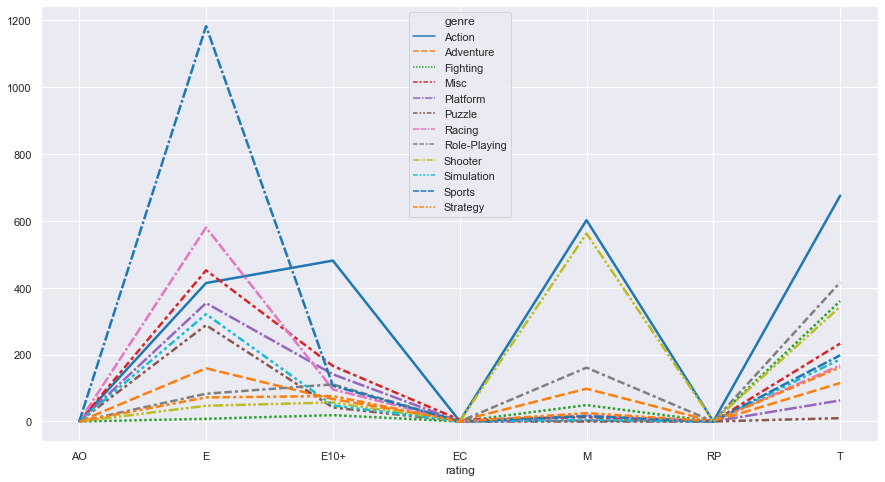

In [70]:
# построим график для кол-ва записей в зависимости от жанра
sns.set(rc = {'figure.figsize':(15,8)})
sns.lineplot(data=df_pt_rat, palette="tab10", linewidth=2.5);

Из графика видно, что для самой распространенной возрастной категории (E - everyone) самый популярный (часто встречающийся в таблице) жанр игр -Sports . Для второй распространенной возрастной категории T - teen -наиболее популярный жанр игр - Action

Посмотрим кол-во записей по годам с указанной возрастной категорией и без. Для этого добавим колонку, в которой укажем установлена категория или нет 

In [71]:
df['rating_lable'] = df['rating']
df['rating_lable'] = df['rating_lable'].fillna('N')

In [72]:
# Заменим значения в колонке rating_lable на R если значение не равно N
df['rating_lable'] = df['rating_lable'].apply(lambda x: 'R' if x != 'N' else x)

In [73]:
df.head(3)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales,rating_lable
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8,E,82.54,R
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24,N
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52,R


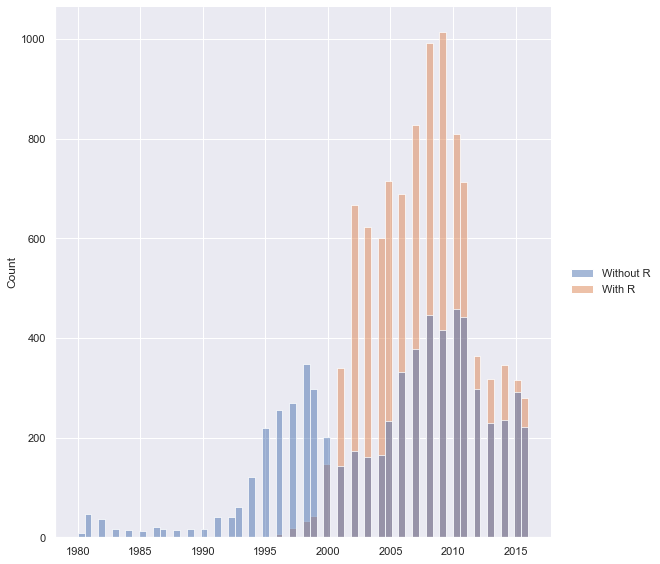

In [74]:
# Посмотрим распределение записей с категорией и без по годам
sns.displot(
    data={
        "Without R": df[df.rating_lable == 'N'].year_of_release,
        "With R": df[df.rating_lable == 'R'].year_of_release
    },height=8);

##### Колонка rating. Выводы:
В колонке 'rating' присутствует много пропусков. Практически у половинны данных отсутствует возрастная категория (41%). Среди записей, у которых определена возрастная категория самой многочисленной является категория E (everyone) - 40%. Следующая категория по популярности - T (teen) - 30%. Самые малочисленные категории - AO (adult only) - всего одна запись, RP (Rating Pending) - 2 записи и EC(Early Childhood - 9 записей.
Так же, указание возрастной категории начинается с 1995 года. До 1995 - возрастная категория не указывалась.  
С 2000 до 2010 года выпуска игр возрастная категория указана для половины игр. После 2010 до 2016 большенство записей без указания возрастной категории.
Мы можем только предполагать, что скорее всего возрастная категория в пропусках или 'E' или 'T' - так как они смамые популярные. Однако, мы не будем заполнять пропуски, т.к предположение категории может внести ошибку больше для анализа чем отсутствие категории.

In [75]:
# Изучим данные в колонке 'critic_score'
data_analysis('critic_score')


----------------------------------------
Анализ данных в колонке critic_score
----------------------------------------
Тип данных в колонке: float64
Количество отсутствующих значений в столбце: 8488
Процент отсутствующих значений: 51.26%
Число уникальных данных: 82
Число уникальных значений слишком велико для вывода
Описание данных в колонке:


count    8072.000000
mean       68.993682
std        13.919101
min        13.000000
25%        60.000000
50%        71.000000
75%        79.000000
max        98.000000
Name: critic_score, dtype: float64

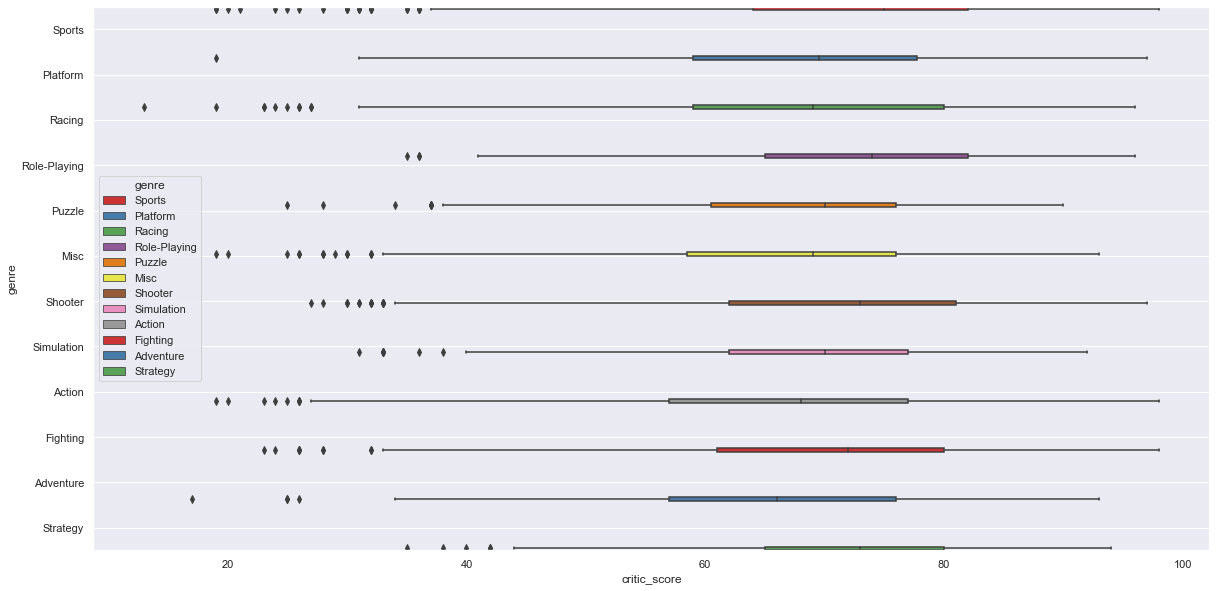

In [76]:
# Посмотрим значение critic_score по каждому жанку
plt.figure(figsize=(20,10))
sns.boxplot(data=df, x='critic_score', y = 'genre', hue='genre', palette="Set1", width=1);
plt.grid()
plt.show();

In [77]:
# Изучим данные в колонке 'user_score'
data_analysis('user_score')


----------------------------------------
Анализ данных в колонке user_score
----------------------------------------
Тип данных в колонке: object
Количество отсутствующих значений в столбце: 6630
Процент отсутствующих значений: 40.04%
Число уникальных данных: 97
Число уникальных значений слишком велико для вывода
Описание данных в колонке:


count     9930
unique      96
top        tbd
freq      2392
Name: user_score, dtype: object

In [78]:
# Посмотрим строки, где оценка пользователя не определена: user_score = tbd
df_tbd = df.query('user_score =="tbd"')
df_tbd.head(5)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales,rating_lable
119,Zumba Fitness,Wii,2010,Sports,3.45,2.59,0.0,0.66,NaN,tbd,E,6.70,R
301,Namco Museum: 50th Anniversary,PS2,2005,Misc,2.08,1.35,0.0,0.54,61.0,tbd,E10+,3.97,R
520,Zumba Fitness 2,Wii,2011,Sports,1.51,1.03,0.0,0.27,NaN,tbd,T,2.81,R
645,uDraw Studio,Wii,2010,Misc,1.65,0.57,0.0,0.20,71.0,tbd,E,2.42,R
717,Just Dance Kids,Wii,2010,Misc,1.52,0.54,0.0,0.18,NaN,tbd,E,2.24,R


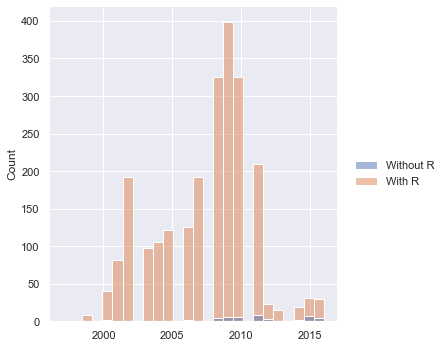

In [79]:
# Посмотрим распределение записей с категорией и без по годам для таблицы с user_score=tbd
sns.displot(
    data={
        "Without R": df_tbd[df_tbd.rating_lable == 'N'].year_of_release,
        "With R": df_tbd[df_tbd.rating_lable == 'R'].year_of_release
    });

Большинство данных имеют возрастную категорию. Посмотрим какая категория наиболее часто встречается

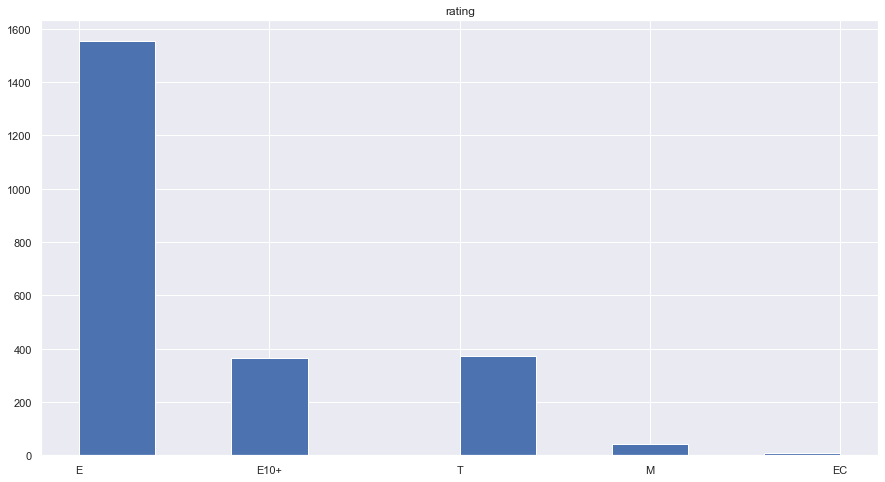

In [80]:
# Построим гистограмму распределения возрастной категории в таблице df_tbd
df_tbd['rating'].hist();
plt.title('rating');

Самая частая категория для записпейс с неопределенной оценкой пользователей (tbd) - Е

Мы знаем, что в таблице есть записи для одной и тойже игры, но на разных платфомах (т.е есть дубликаты по названиям).

Проверим, есть ли среди дублирующих игр строки, с оценкой пользователей tbd и с отличной от tbd оценкой. Это нам позволит понять логику, почему как оценка пользователя указано tbd. Возможно, оценка tbd стоит для игр с низкими продажами

In [81]:
# Создадим таблицу, где оценка пользователей равна tbd и не отсутствует
df_user_bd = df.query('user_score =="tbd" and user_score.notna()')
df_user_bd.head(3)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales,rating_lable
119,Zumba Fitness,Wii,2010,Sports,3.45,2.59,0.0,0.66,NaN,tbd,E,6.70,R
301,Namco Museum: 50th Anniversary,PS2,2005,Misc,2.08,1.35,0.0,0.54,61.0,tbd,E10+,3.97,R
520,Zumba Fitness 2,Wii,2011,Sports,1.51,1.03,0.0,0.27,NaN,tbd,T,2.81,R


In [82]:
# создадим сводную таблицу по количеству дубликатов игр в таблице, где оценка пользователя равна tbd
df_name_tbd = df_user_bd.pivot_table(index='name', values='platform', aggfunc='count').sort_values(by='platform',ascending=False)
df_name_tbd = df_name_tbd.reset_index()
df_name_tbd

,name,platform
0,Wipeout 2,5
1,Cars: Race-O-Rama,5
2,Just Dance 2017,5
3,DreamWorks Super Star Kartz,5
4,Ben 10 Galactic Racing,5
...,...,...
1908,Hummer Badlands,1
1909,How to Train Your Dragon,1
1910,Hot Wheels: Stunt Track Challenge,1
1911,Hot Wheels: Burnin' Rubber,1


In [83]:
# Добавим в предыдущую таблицу колонку с кол-ом записей для названий игр, которые встеречаются в исходной таблице
nb_game = []
for index, row in df_name_tbd.iterrows():
    game_name = df_name_tbd.at[index, 'name']
    nb_total = len(df[(df['name'] ==game_name)])
    nb_game.append(nb_total)
df_name_tbd['total_nb_duplicates'] = nb_game

In [84]:
df_name_tbd.head(3)

,name,platform,total_nb_duplicates
0,Wipeout 2,5,5
1,Cars: Race-O-Rama,5,6
2,Just Dance 2017,5,6


In [85]:
# добавим колонку с разнице между кол-вом записей, где оценка пользователя =tbd и общим кол-ом дубликатов
df_name_tbd['delta'] = df_name_tbd['total_nb_duplicates'] - df_name_tbd['platform']

In [86]:
# посмотрим на таблицу с добавленной колонкой
df_name_tbd.query('delta>0').sort_values(by='delta',ascending=False).head(10)

,name,platform,total_nb_duplicates,delta
1605,Monopoly,1,8,7
243,Ratatouille,2,9,7
1663,Madden NFL 08,1,8,7
1496,Lego Star Wars: The Force Awakens,1,7,6
1508,LEGO The Lord of the Rings,1,7,6
252,LEGO Harry Potter: Years 5-7,2,8,6
1206,FIFA Soccer 11,1,7,6
1014,Star Wars The Clone Wars: Republic Heroes,1,7,6
880,Skylanders: SuperChargers,1,7,6
1664,Madden NFL 06,1,7,6


In [87]:
# Посмотрим на все записи для игры с названием Monopoly
df.query('name=="Monopoly"').sort_values(by='sales',ascending=False)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales,rating_lable
658,Monopoly,PC,1994,Misc,1.49,0.81,0.0,0.10,NaN,NaN,NaN,2.40,N
912,Monopoly,Wii,2008,Misc,0.86,0.83,0.0,0.20,70.0,7.8,E,1.89,R
1249,Monopoly,PS,1997,Misc,1.18,0.27,0.0,0.05,NaN,NaN,NaN,1.50,N
3382,Monopoly,X360,2008,Misc,0.34,0.20,0.0,0.06,56.0,5.8,E,0.60,R
4521,Monopoly,PS2,2008,Misc,0.21,0.16,0.0,0.05,NaN,7.2,E,0.42,R
5389,Monopoly,PS3,2008,Misc,0.25,0.05,0.0,0.04,54.0,6.7,E,0.34,R
6340,Monopoly,DS,2010,Misc,0.15,0.09,0.0,0.02,NaN,tbd,NaN,0.26,N
7397,Monopoly,N64,1999,Misc,0.17,0.04,0.0,0.00,NaN,NaN,NaN,0.21,N


In [88]:
# Посмотрим на все записи для игры с названием Lego Star Wars: The Force Awakens
df.query('name=="Lego Star Wars: The Force Awakens"').sort_values(by='sales',ascending=False)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales,rating_lable
2916,Lego Star Wars: The Force Awakens,PS4,2016,Action,0.16,0.43,0.01,0.11,78.0,7.5,E10+,0.71,R
5925,Lego Star Wars: The Force Awakens,XOne,2016,Action,0.14,0.13,0.00,0.02,76.0,7,E10+,0.29,R
8565,Lego Star Wars: The Force Awakens,PS3,2016,Action,0.04,0.10,0.00,0.03,NaN,tbd,E10+,0.17,R
8942,Lego Star Wars: The Force Awakens,WiiU,2016,Action,0.06,0.07,0.01,0.01,74.0,8,E10+,0.15,R
9718,Lego Star Wars: The Force Awakens,3DS,2016,Action,0.04,0.07,0.01,0.01,NaN,7.8,E10+,0.13,R
9805,Lego Star Wars: The Force Awakens,X360,2016,Action,0.05,0.06,0.00,0.01,NaN,6.9,E10+,0.12,R
10818,Lego Star Wars: The Force Awakens,PSV,2016,Action,0.01,0.06,0.01,0.02,NaN,7.1,E10+,0.10,R


In [89]:
# Посмотрим на все записи для игры с названием Star Wars The Clone Wars: Republic Heroes
df.query('name=="Star Wars The Clone Wars: Republic Heroes"').sort_values(by='sales',ascending=False)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales,rating_lable
2580,Star Wars The Clone Wars: Republic Heroes,Wii,2009,Action,0.43,0.29,0.0,0.07,48.0,6.4,T,0.79,R
4484,Star Wars The Clone Wars: Republic Heroes,PS3,2009,Action,0.19,0.18,0.0,0.07,43.0,5.3,T,0.44,R
4768,Star Wars The Clone Wars: Republic Heroes,PSP,2009,Action,0.21,0.12,0.0,0.07,NaN,tbd,T,0.40,R
4863,Star Wars The Clone Wars: Republic Heroes,DS,2009,Action,0.22,0.14,0.0,0.04,NaN,5.3,E10+,0.40,R
4919,Star Wars The Clone Wars: Republic Heroes,X360,2009,Action,0.18,0.17,0.0,0.04,43.0,6.3,T,0.39,R
6592,Star Wars The Clone Wars: Republic Heroes,PS2,2009,Action,0.17,0.01,0.0,0.08,NaN,8.3,T,0.26,R
14896,Star Wars The Clone Wars: Republic Heroes,PC,2009,Action,0.00,0.02,0.0,0.00,46.0,4.7,T,0.02,R


Мы посмотрели записи для 3х игр. Зависимость кол-ва продаж и оценки пользователей tbd (оценка не определена) для одной и той же игры не наблюдается. 

Мы не будем исключать строки величиной tbd. Однако, это обозначение не несет информацию об оценке пользователей. В таком случае, поменяем значение tbd на NaN

In [90]:
# замена tbd на nan
df['user_score'] = df['user_score'].replace('tbd', np.nan)

In [91]:
df['user_score'].describe()

count     7538
unique      95
top        7.8
freq       324
Name: user_score, dtype: object

In [92]:
#Количество пропусков в колонке user_score
len(df.query('user_score.isna()'))

9022

Изменим тип данных на цифровой и сравним оценки пользователей с оценкой критиков

In [93]:
df['user_score'] = df['user_score'].astype(float, errors='ignore')

In [94]:
df['user_score'].describe()

count    7538.000000
mean        7.125842
std         1.497995
min         0.000000
25%         6.400000
50%         7.500000
75%         8.200000
max         9.700000
Name: user_score, dtype: float64

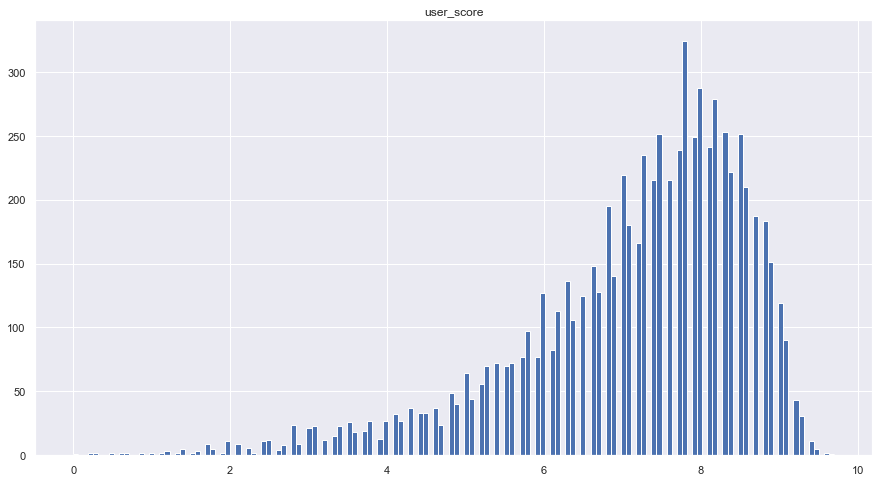

In [95]:
# Построим гистограмму распределения оценок пользователей
df['user_score'].hist(bins=150);
plt.title('user_score');

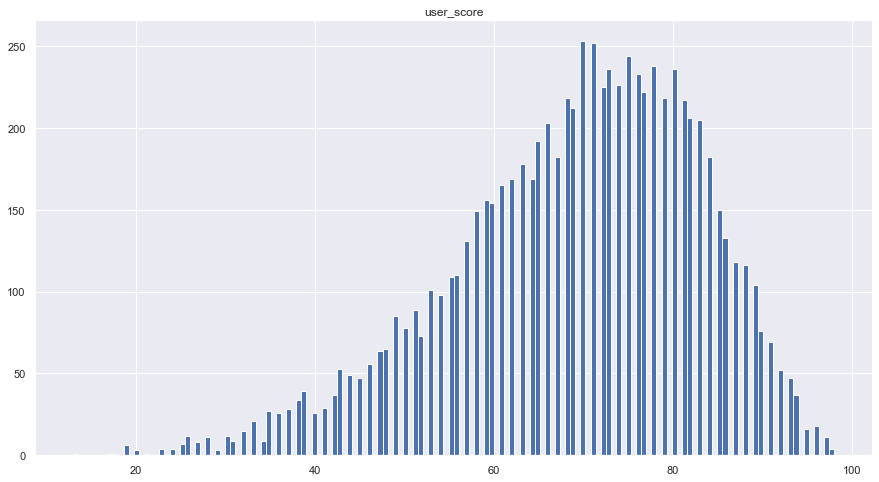

In [96]:
# Построим гистограмму распределения оценок критиков
df['critic_score'].hist(bins=150);
plt.title('user_score');

In [97]:
# Посмотрим медианные значения оценок по жанрам игр
df.pivot_table(index='genre', values=['critic_score', 'user_score'], aggfunc= ['median'])

median           
             critic_score user_score
genre                               
Action               68.0        7.4
Adventure            66.0        7.6
Fighting             72.0        7.6
Misc                 69.0        7.1
Platform             69.5        7.7
Puzzle               70.0        7.5
Racing               69.0        7.4
Role-Playing         74.0        7.8
Shooter              73.0        7.4
Simulation           70.0        7.5
Sports               75.0        7.4
Strategy             73.0        7.8

In [98]:
# Изучим данные в колонке 'critic_score'
data_analysis('critic_score')


----------------------------------------
Анализ данных в колонке critic_score
----------------------------------------
Тип данных в колонке: float64
Количество отсутствующих значений в столбце: 8488
Процент отсутствующих значений: 51.26%
Число уникальных данных: 82
Число уникальных значений слишком велико для вывода
Описание данных в колонке:


count    8072.000000
mean       68.993682
std        13.919101
min        13.000000
25%        60.000000
50%        71.000000
75%        79.000000
max        98.000000
Name: critic_score, dtype: float64

In [99]:
# Изучим данные в колонке 'user_score'
data_analysis('user_score')


----------------------------------------
Анализ данных в колонке user_score
----------------------------------------
Тип данных в колонке: float64
Количество отсутствующих значений в столбце: 9022
Процент отсутствующих значений: 54.48%
Число уникальных данных: 96
Число уникальных значений слишком велико для вывода
Описание данных в колонке:


count    7538.000000
mean        7.125842
std         1.497995
min         0.000000
25%         6.400000
50%         7.500000
75%         8.200000
max         9.700000
Name: user_score, dtype: float64

Практически для половины записей отсутствуют оценки критиков и пользователей. Оценка критиков определяется 100-й шкалой, оценка пользователей - 10-й. 

В среднем (медианное значение) оценка критиков чуть ниже, но близка к оценке пользователей: 71 балл (оценка критиков) и 7,5 (оценка пользователей).
Мы не будем заполнять пропуски, т.к их слишком много и это заполнение может внести большую ошибку. Поищем причину пропусков

In [100]:
df.head(3)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales,rating_lable
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54,R
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24,N
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52,R


Удалим колонку rating_lable, т.к она больше не нужна

In [101]:
df.drop(['rating_lable'], axis=1, inplace=True)

In [102]:
df.head(3)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52


In [103]:
# Обновим индексы
df.reset_index(inplace=True)

In [104]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16560 entries, 0 to 16559
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   index            16560 non-null  int64  
 1   name             16560 non-null  object 
 2   platform         16560 non-null  object 
 3   year_of_release  16560 non-null  int32  
 4   genre            16560 non-null  object 
 5   na_sales         16560 non-null  float64
 6   eu_sales         16560 non-null  float64
 7   jp_sales         16560 non-null  float64
 8   other_sales      16560 non-null  float64
 9   critic_score     8072 non-null   float64
 10  user_score       7538 non-null   float64
 11  rating           9863 non-null   object 
 12  sales            16560 non-null  float64
dtypes: float64(7), int32(1), int64(1), object(4)
memory usage: 1.6+ MB


In [105]:
print(f'Количество удаленных строк {1-len(df)/len(df_init):.2%}')

Количество удаленных строк 0.93%


Возможно пропуски с оценке связаны с кол-м продаж с регионах. Проверим связь кол-ва продаж с наличием оценки критиков и пользователей.

Добавим колонку с процентом кол-ва продаж в Северной Америке по отношению с общими продажами

In [106]:
df['ratio_na'] = df['na_sales']*100/df['sales']

In [107]:
# Добавим колонку с процентом кол-ва продаж в Японии по отношению с общими продажами
df['ratio_jp'] = df['jp_sales']*100/df['sales']

In [108]:
# Добавим колонку с процентом кол-ва продаж в Европе по отношению с общими продажами
df['ratio_eu'] = df['eu_sales']*100/df['sales']

In [109]:
# Добавим колонку с процентом кол-ва продаж в других регионах по отношению с общими продажами
df['ratio_other'] = df['other_sales']*100/df['sales']

In [110]:
# Добавим колонку для обозначения имеется ли оценка критиков или нет
df['critical_score_if'] = df.apply(lambda x: 'N' if np.isnan(x['critic_score']) else 'Y', axis=1) 

In [111]:
df.head(10)

,index,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales,ratio_na,ratio_jp,ratio_eu,ratio_other,critical_score_if
0,0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54,50.109038,4.567482,35.086019,10.237461,Y
1,1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24,72.266402,16.923459,8.896620,1.913519,N
2,2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52,44.144144,10.670045,35.923423,9.262387,Y
3,3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77,47.635032,10.009155,33.353677,9.002136,Y
4,4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38,35.914595,32.568515,28.330147,3.186743,N
5,5,Tetris,GB,1989,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN,30.26,76.668870,13.945803,7.468605,1.916722,N
6,6,New Super Mario Bros.,DS,2006,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E,29.80,37.852349,21.812081,30.671141,9.664430,Y
7,7,Wii Play,Wii,2006,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E,28.91,48.287790,10.134901,31.753718,9.823590,Y
8,8,New Super Mario Bros. Wii,Wii,2009,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E,28.32,50.988701,16.596045,24.505650,7.909605,Y
9,9,Duck Hunt,NES,1984,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN,28.31,95.125397,0.989050,2.225362,1.660191,N


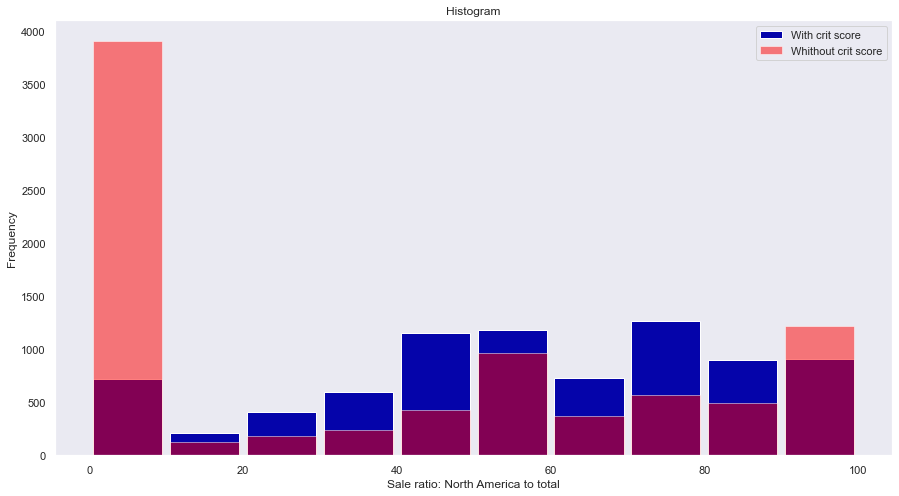

In [112]:
# Гистограмма распределения процента продаж по Северной Америке с учетом присутствия оценки критиков и без оценки критиков
df[df['critical_score_if']=='Y']['ratio_na'].plot.hist(grid=True, rwidth=0.9, color='#0504aa')
df[df['critical_score_if']=='N']['ratio_na'].plot.hist(grid=True, rwidth=0.9, color='red',alpha=0.5)
plt.title('Histogram')
plt.xlabel('Sale ratio: North America to total')
plt.ylabel('Frequency')
plt.legend(labels=('With crit score','Whithout crit score'))
plt.grid()
plt.show()

Видно, что игры с низкими продажами в Северной Америке (менее 10-15%) в основном не имеют оценок критиков. 

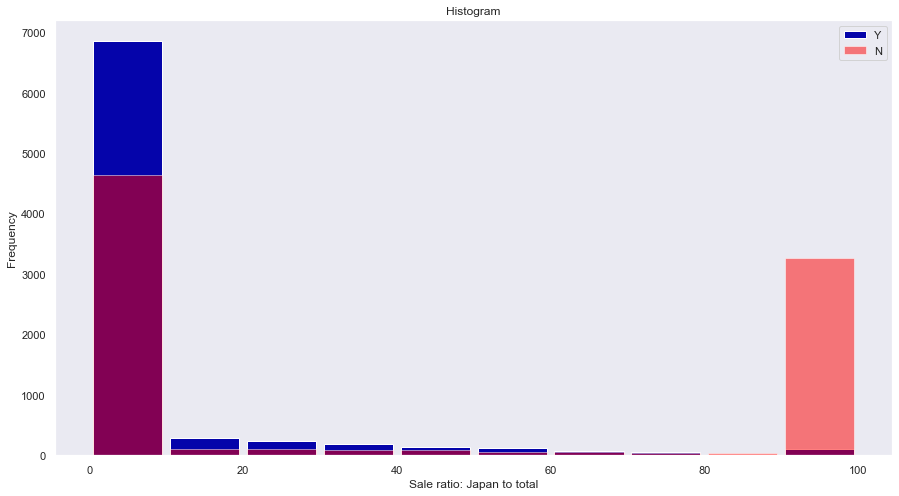

In [113]:
# Гистограмма распределения процента продаж в Японии с учетом присутствия оценки критиков и без оценки критиков
df[df['critical_score_if']=='Y']['ratio_jp'].plot.hist(grid=True, rwidth=0.9, color='#0504aa')
df[df['critical_score_if']=='N']['ratio_jp'].plot.hist(grid=True, rwidth=0.9, color='red',alpha=0.5)
plt.title('Histogram')
plt.xlabel('Sale ratio: Japan to total')
plt.ylabel('Frequency')
plt.legend(labels=('Y','N'))
plt.grid()
plt.show()

Видно, что игры с высокими продажами в Японии (<90%) в основном не имеют оценок критиков. Таким образом, можно предположить, что популярные игры в Японии не имеют оценок критиков.  

In [114]:
# добавим колонку с обозначением если есть оценка пользователей или нет
df['user_score_if'] = df.apply(lambda x: 'N' if np.isnan(x['user_score']) else 'Y', axis=1) 

In [115]:
df.head(3)

,index,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales,ratio_na,ratio_jp,ratio_eu,ratio_other,critical_score_if,user_score_if
0,0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54,50.109038,4.567482,35.086019,10.237461,Y,Y
1,1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24,72.266402,16.923459,8.896620,1.913519,N,N
2,2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52,44.144144,10.670045,35.923423,9.262387,Y,Y


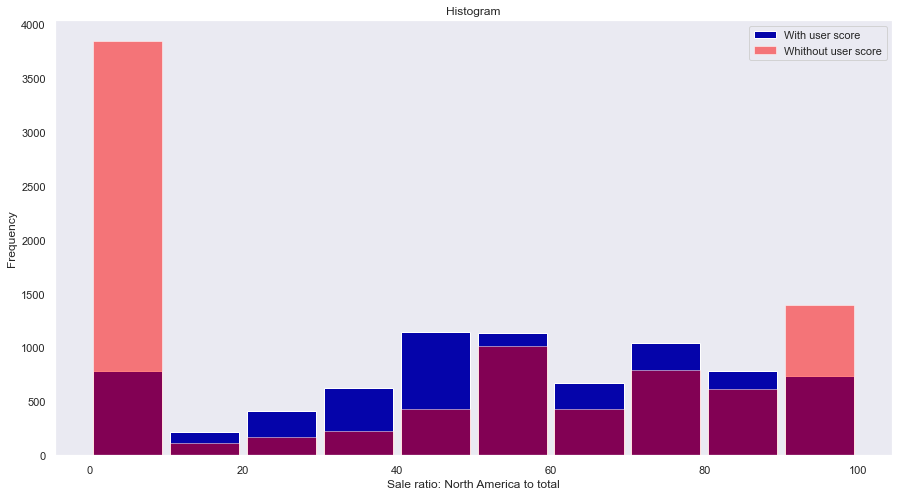

In [116]:
# Гистограмма распределения процента продаж по Северной Америке с учетом присутствия оценки пользователей и без оценки пользователей
df[df['user_score_if']=='Y']['ratio_na'].plot.hist(grid=True, rwidth=0.9, color='#0504aa')
df[df['user_score_if']=='N']['ratio_na'].plot.hist(grid=True, rwidth=0.9, color='red',alpha=0.5)
plt.title('Histogram')
plt.xlabel('Sale ratio: North America to total')
plt.ylabel('Frequency')
plt.legend(labels=('With user score','Whithout user score'))
plt.grid()
plt.show()

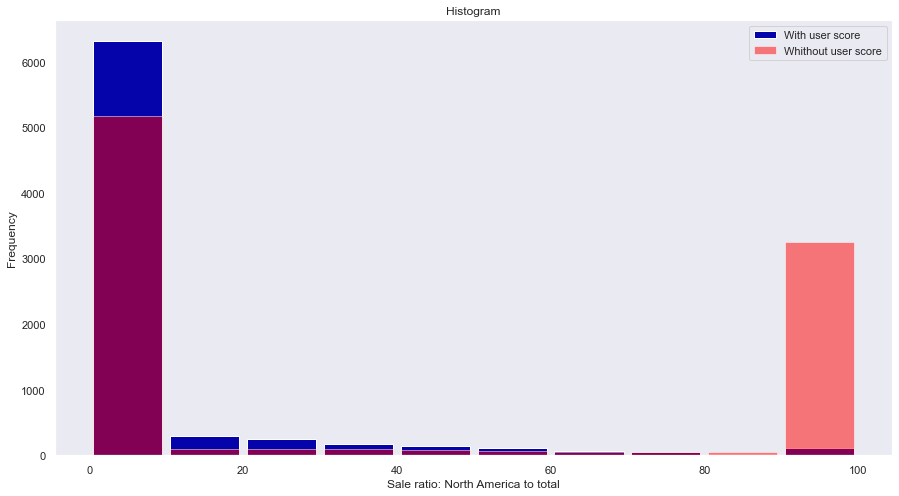

In [117]:
# Гистограмма распределения процента продаж в Японии с учетом присутствия оценки пользователей и без оценки пользователей
df[df['user_score_if']=='Y']['ratio_jp'].plot.hist(grid=True, rwidth=0.9, color='#0504aa')
df[df['user_score_if']=='N']['ratio_jp'].plot.hist(grid=True, rwidth=0.9, color='red',alpha=0.5)
plt.title('Histogram')
plt.xlabel('Sale ratio: North America to total')
plt.ylabel('Frequency')
plt.legend(labels=('With user score','Whithout user score'))
plt.grid()
plt.show()

Видно, что игры с высокими продажами в Японии (<90%) в основном не имеют оценок пользователей. Таким образом, можно предположить, что популярные игры в Японии не имеют оценок пользователей. 

#####  Выводы по колонке user_score and critic_sore:
Пропуски в оценках критиков и пользователей были проанализированы - оценки критиков и пользователей в основном присутствуют для игр, популярных за пределами Японии. Т.е можно предположить, что пользователи и критики в Японии не оставляют оценок.

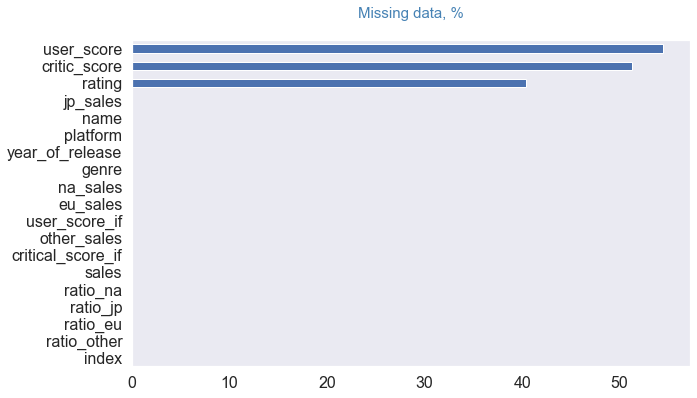

In [118]:
# Проверим кол-во пропусков в таблице после всех изменений
pass_value(df)
plt.grid()

In [119]:
# Посмотрим описание таблицы после всех изменений
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16560 entries, 0 to 16559
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   index              16560 non-null  int64  
 1   name               16560 non-null  object 
 2   platform           16560 non-null  object 
 3   year_of_release    16560 non-null  int32  
 4   genre              16560 non-null  object 
 5   na_sales           16560 non-null  float64
 6   eu_sales           16560 non-null  float64
 7   jp_sales           16560 non-null  float64
 8   other_sales        16560 non-null  float64
 9   critic_score       8072 non-null   float64
 10  user_score         7538 non-null   float64
 11  rating             9863 non-null   object 
 12  sales              16560 non-null  float64
 13  ratio_na           16560 non-null  float64
 14  ratio_jp           16560 non-null  float64
 15  ratio_eu           16560 non-null  float64
 16  ratio_other        165

In [120]:
print(f'Количество удаленных строк {1 - len(df)/len(df_init):.2%}')

Количество удаленных строк 0.93%


### Выводы:
После предобработки данных было удалено менее 1% данных. В таблице осталось 16560 записи.
Но в трех колонках отсутствуют данные практически для пловины строк: 
* Оценка пользователей не определена для 54% данных;
* Оценка критиков не определена для 51% данных;
* Возрастная категория не определена для 40% данных.

Года издания игр распределены от 1980 до 2016 года, причем в таблице большая чать записей соответствует играм, выпущеным до 2010 года. Практически четверть данных соответствует играм, выпущеным до 2003 года. 

Для анализа кол-ва продаж были созданы дополнительные колонки - процент продаж по 4м регионам и колонка с общими продажами во всех 4х регионах.
На этом предобработка данных завершена

## Исследовательский анализ данных

#### 1. Посмотрим, сколько игр выпускалось в разные годы

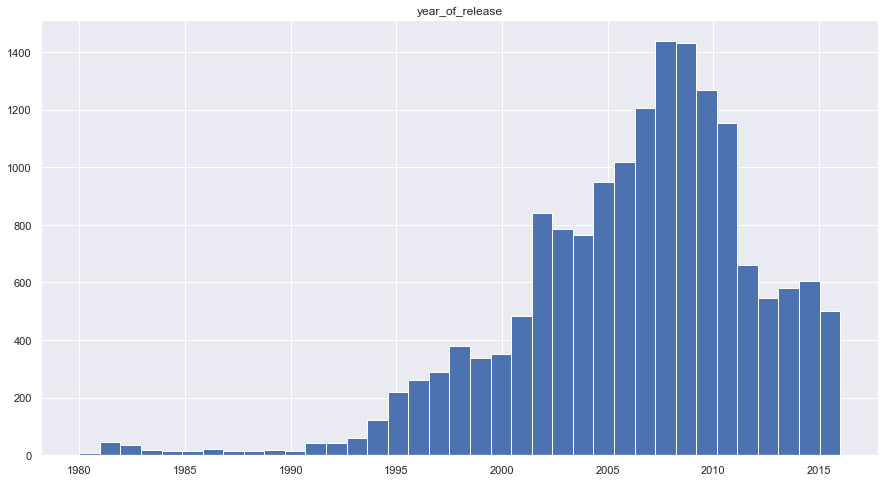

In [121]:
# Построим гистограмму распределения данных по годам издания игр
df['year_of_release'].hist(bins=len(df['year_of_release'].unique()));
plt.title('year_of_release');

Видно, что в таблице мало записей для игр, выпущеных до 1995 года. Также, количество записей в таблице за 2015 - 2016 годы не велико - около 10% от всех записей. Больше всего записей для игр, выпущенных в 2008 и 2009 годах. 

Данные за все периоды для анализа потенциально прибольного продукта не важны. Важны данные, по которым можно отследить тенденцию изменения вкусов пользователей, а также учесть актуальные возможности компьютерной техники. Т.к мы планируем кампанию на 2017 по данным до 2016 года, то, пожалуй, для анализа достаточно данных за последние 10 лет (сточки зрения популярности жанров), однако, необходимо оценить какие платформы поддерживают игры за последние несколько лет. 

#### 2. Посмотрим, как менялись продажи по платформам

In [122]:
df_platform = df.pivot_table(index='platform', values='sales',columns='year_of_release', aggfunc='sum')
df_platform

year_of_release,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
platform,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2600,11.38,35.68,28.88,5.84,0.27,0.45,0.67,1.94,0.74,0.63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3DO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.02,0.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3DS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.30,63.20,51.76,56.57,43.76,27.78,15.14
DC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.38,5.16,5.99,1.07,0.29,NaN,NaN,NaN,NaN,0.02,0.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DS,NaN,NaN,NaN,NaN,NaN,0.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.27,130.14,119.81,147.23,145.36,119.56,85.35,26.33,11.67,1.54,NaN,NaN,NaN
GB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.43,64.97,4.89,5.57,25.49,NaN,12.18,3.60,36.03,6.37,26.90,38.00,19.76,9.24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GBA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.07,61.53,74.16,56.67,77.91,34.53,5.46,3.40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.62,51.92,51.50,28.82,27.91,11.55,0.27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GEN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.60,4.33,12.64,0.65,8.13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


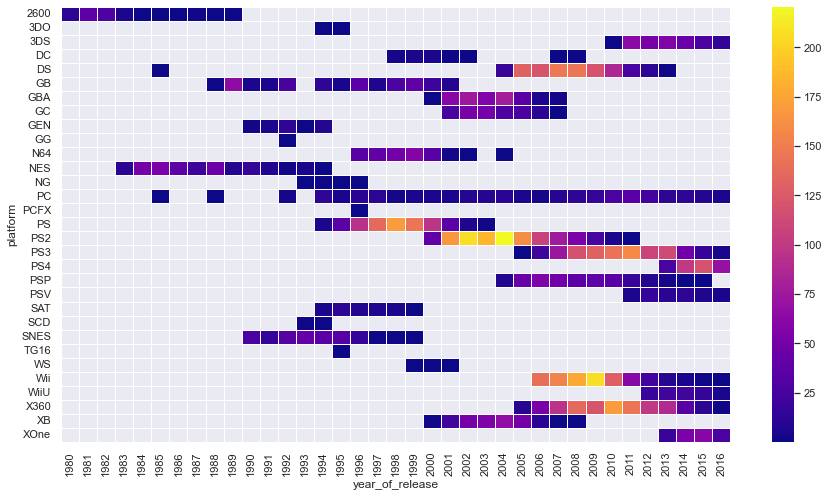

In [123]:
# Построим тепловую мартицу
sns.heatmap(df_platform, annot=False, linewidths=.5, cmap="plasma");

In [124]:
df_platform.reset_index(drop=False, inplace=True)

In [125]:
df_platform.head(3)

year_of_release,platform,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,2600,11.38,35.68,28.88,5.84,0.27,0.45,0.67,1.94,0.74,0.63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3DO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.02,0.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3DS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.3,63.2,51.76,56.57,43.76,27.78,15.14


In [126]:
# Посмотрим сколько лет каждая платформа поддерживала новые игры
# Добавим в предыдущую таблицу колонку с кол-ом лет с не нулевыми продажами
nb_years = []
for index, row in df_platform.iterrows():
    count = 0
    for i in range(1980,2017):
        if pd.isna(df_platform.at[index,i]):
            count += 0
        else:
            count += 1
    nb_years.append(count)

In [127]:
df_platform['nb_years_plt'] = nb_years

In [128]:
# Описание колонки с числом лет поддержки новых игр
df_platform['nb_years_plt'].describe()

count    31.000000
mean      7.774194
std       5.097121
min       1.000000
25%       4.000000
50%       7.000000
75%      11.000000
max      26.000000
Name: nb_years_plt, dtype: float64

Получается, в среднем, платформы поддерживают 7 лет игры

Посмотрим, какие платформы поддерживают игры, выпущенные в 2016 году

In [129]:
# Сприсок платформ, поддерживающих игры, выпущенные в 2016году
df_platform[df_platform[2016].notna()]['platform']

2      3DS
13      PC
17     PS3
18     PS4
20     PSV
26     Wii
27    WiiU
28    X360
30    XOne
Name: platform, dtype: object

Всего 9 платформ поддерживают игры, выпущенные в 2016 году.

За последние 5 лет (начиная с 2011) появилось 3 новых платформ: XOne, WiiU и PS4. И 3 платформы (DS, PS2 и PSP) прекратили поддерживать новые игры (игы, выпущенные с 2011 по 2016 годы).
Видно, что на смену PS(существовала 10лет) пришла PS2(существовала 12лет), потом PS3(существует 12лет) и уже появилась PS4(существует 4 года, включая 2016 год).

Можно предположить, что PS4 продолжит существовать, тогда как PS3 скорее всего закончит существавание в ближайшие годы.

Можно выделить 4х основных игрока на рынке игровых платформ: 
* серии XBox (XB, X360, XOne)
* серии PlayStation (PS, PS2, PS3, PS4, PSP, PSV)
* серии от Nintendo (DS, 3DS, Wii... и т.д)
* PC - персональный компьютер

Из тепловой матрицы видно, что серии платформ сменяют одна другую в течении лет, а платформа PC(персональный компьютер) - стабильно существует с 1994 по настоящий год. Продолжительность существования одной серии платформы (из списка выше за исключением PC) - примерно 10 лет.

In [130]:
# Таблица для платформ, поддерживающих игры, выпущенные в 2016году
df_platform[df_platform[2016].notna()]

year_of_release,platform,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,nb_years_plt
2,3DS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.30,63.20,51.76,56.57,43.76,27.78,15.14,7
13,PC,NaN,NaN,NaN,NaN,NaN,0.04,NaN,NaN,0.03,NaN,NaN,NaN,3.03,NaN,12.87,4.22,10.58,11.27,3.26,4.74,4.66,5.47,8.57,8.89,10.39,4.38,2.85,9.28,12.46,17.05,26.15,35.16,23.45,12.66,13.28,8.52,5.25,26
17,PS3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.19,20.96,73.19,118.79,130.93,142.96,157.98,108.28,113.25,47.76,16.82,3.60,12
18,PS4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.99,100.00,118.90,69.25,4
20,PSV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.63,16.19,10.59,11.90,6.25,4.25,6
26,Wii,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,139.72,153.88,177.68,206.97,128.67,59.79,22.94,8.59,3.75,1.14,0.18,11
27,WiiU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.56,21.65,22.03,16.35,4.60,5
28,X360,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.64,52.37,95.42,136.07,120.82,170.55,145.28,100.72,88.58,34.74,11.96,1.52,12
30,XOne,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.96,54.07,60.14,26.15,4


In [131]:
# замена индексов колонкой platform
df_platform.set_index('platform', inplace=True)

In [132]:
df_platform.head(3)

year_of_release,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,nb_years_plt
platform,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2600,11.38,35.68,28.88,5.84,0.27,0.45,0.67,1.94,0.74,0.63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10
3DO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.02,0.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
3DS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.3,63.2,51.76,56.57,43.76,27.78,15.14,7


In [133]:
# удаление клонки nb_years_plt
df_platform.drop(['nb_years_plt'], axis=1, inplace=True)

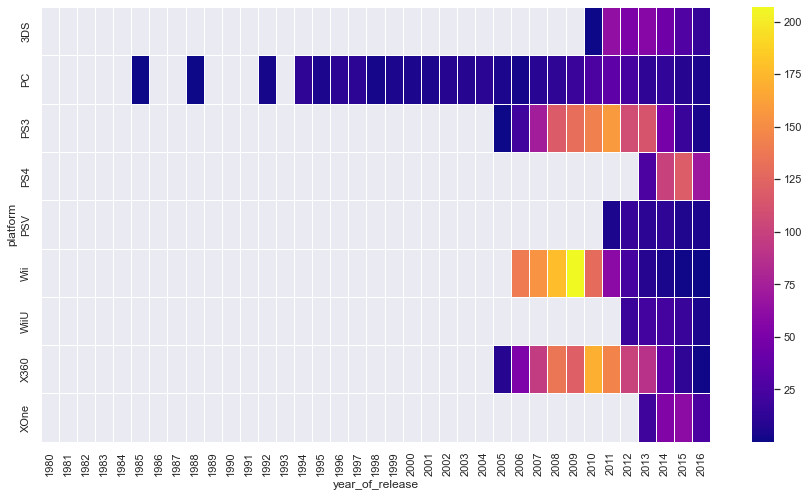

In [134]:
# Построим тепловую мартицу для платформ, поддерживающих игры 2016 года
sns.heatmap(df_platform[df_platform[2016].notna()], annot=False, linewidths=.5, cmap="plasma");

Мы видим, что кол-во продаж убывает с увеличением года. Скорее всего это связано с тем, что предоставленные данные соответствуют кол-ву продаж начиная с года выпуска игры до 2016 года включительно. Т.е, например, для платформы Wii в 2009 году была выпущена игра, которая остается популярной и ее покупали и в 2016 году.

Выбирем потенциально прибыльные платформы на 2017 год:
* XOne (серия XBox, существует 4 года)
* PS4 (серия PlayStation, существует 4 года)
* WiiU (серия Wii от Nintendo, существует 5 лет)
* PC (стабильно существует с 1994 года)

Возьмем период для исследования 2013-2016 (4 года) - т.к начиная с 2013 существовали все интерисующие нас платформы.

In [135]:
df_set_platform = df[(df['platform'] == 'XOne') | (df['platform'] == 'PS4') |
                    (df['platform'] == 'WiiU') | (df['platform'] == 'PC')]

In [136]:
df_set_platform 

,index,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales,ratio_na,ratio_jp,ratio_eu,ratio_other,critical_score_if,user_score_if
31,31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,NaN,14.63,41.216678,2.460697,40.054682,16.267943,N,N
42,42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62,31.378764,3.011094,50.000000,15.610143,Y,Y
77,77,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82.0,4.3,E,8.58,13.053613,0.699301,71.328671,14.918415,Y,Y
85,85,The Sims 3,PC,2009,Simulation,0.99,6.42,0.00,0.60,86.0,7.6,T,8.01,12.359551,0.000000,80.149813,7.490637,Y,Y
87,87,Star Wars Battlefront (2015),PS4,2015,Shooter,2.99,3.49,0.22,1.28,NaN,NaN,NaN,7.98,37.468672,2.756892,43.734336,16.040100,N,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16536,16688,Pony Friends 2,PC,2009,Simulation,0.00,0.01,0.00,0.00,NaN,NaN,NaN,0.01,0.000000,0.000000,100.000000,0.000000,N,N
16538,16690,Metal Gear Solid V: Ground Zeroes,PC,2014,Action,0.00,0.01,0.00,0.00,80.0,7.6,M,0.01,0.000000,0.000000,100.000000,0.000000,Y,Y
16542,16694,Breach,PC,2011,Shooter,0.01,0.00,0.00,0.00,61.0,5.8,T,0.01,100.000000,0.000000,0.000000,0.000000,Y,Y
16548,16700,STORM: Frontline Nation,PC,2011,Strategy,0.00,0.01,0.00,0.00,60.0,7.2,E10+,0.01,0.000000,0.000000,100.000000,0.000000,Y,Y


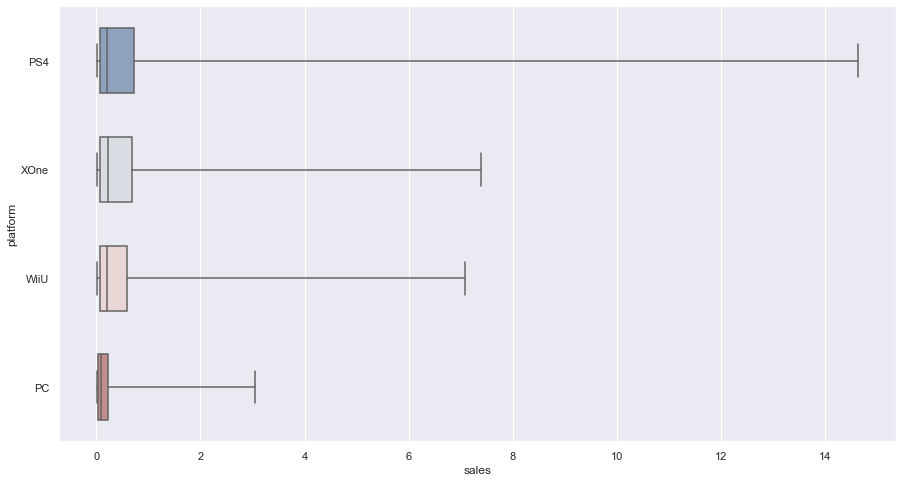

In [137]:
# Построим "ящик с усами" для 3х выбранных платформ с глобальными продажами игр 2016 года"
sns.boxplot(x="sales", y="platform", data=df_set_platform.query('year_of_release>=2013'),
            whis=[0, 100], width=.6, palette="vlag");

In [138]:
#Построим сводную таблицу по платформам и кол-ву продаж
df_set_platform.query('year_of_release>=2013').pivot_table(index='platform', values='sales',aggfunc= ['mean', 'var','std', 'median','count'])

,mean,var,std,median,count
,sales,sales,sales,sales,sales
platform,,,,,
PC,0.207906,0.122899,0.350569,0.08,191
PS4,0.801378,2.590350,1.609456,0.20,392
WiiU,0.562000,1.079060,1.038778,0.20,115
XOne,0.645020,1.073584,1.036139,0.22,247


In [139]:
df_set_platform.query('year_of_release>=2013 and platform=="XOne"')['sales'].describe()

count    247.000000
mean       0.645020
std        1.036139
min        0.010000
25%        0.060000
50%        0.220000
75%        0.685000
max        7.390000
Name: sales, dtype: float64

In [140]:
df_set_platform.query('year_of_release>=2013 and platform=="WiiU"')['sales'].describe()

count    115.000000
mean       0.562000
std        1.038778
min        0.010000
25%        0.060000
50%        0.200000
75%        0.595000
max        7.090000
Name: sales, dtype: float64

In [141]:
df_set_platform.query('year_of_release>=2013 and platform=="PC"')['sales'].describe()

count    191.000000
mean       0.207906
std        0.350569
min        0.010000
25%        0.030000
50%        0.080000
75%        0.225000
max        3.050000
Name: sales, dtype: float64

In [142]:
df_set_platform.query('year_of_release>=2013 and platform=="PS4"')['sales'].describe()

count    392.000000
mean       0.801378
std        1.609456
min        0.010000
25%        0.060000
50%        0.200000
75%        0.730000
max       14.630000
Name: sales, dtype: float64

* Большая часть игр для платформы PS4 (75%) имеет кол-во продаж до 730 тыс. копий
* Большая часть игр для платформы XOne (75%) имеет кол-во продаж до 685 тыс. копий
* Большая часть игр для платформы WiiU (75%) имеет кол-во продаж до 595 тыс. копий
* Большая часть игр для платформы PC (75%) имеет кол-во продаж до 225 тыс. копий

* Медианное кол-во продаж игр для платформы PS4 200 тыс. копий
* Медианное кол-во продаж игр для платформы XOne 220 тыс. копий
* Медианное кол-во продаж игр для платформы WiiU 200 тыс. копий
* Медианное кол-во продаж игр для платформы PC 80 тыс. копий

* Максимальное кол-во проданных игр для платформы PS4 14.6 млн. копий (самое высокое значение среди 4х платформ)
* Максимальное кол-во проданных игр для платформ XOne и WiiU практически одинаковое (7,39 и 7,1 млн.копий соответственно)
* Максимальное кол-во проданных игр для платформы PC 3 млн. копий (самое низкое значение среди 4х платформ)

#### 3. Посмотрим, как влияет на продажи внутри одной популярной платформы отзывы пользователей и критиков

In [143]:
# Создадим таблицу для платформы PS4 c играми, выпущенными с 2013 до 2016 года
df_PS4 = df.query('platform=="PS4" and year_of_release>=2013')
df_PS4.head(3)

,index,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales,ratio_na,ratio_jp,ratio_eu,ratio_other,critical_score_if,user_score_if
31,31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,NaN,14.63,41.216678,2.460697,40.054682,16.267943,N,N
42,42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62,31.378764,3.011094,50.000000,15.610143,Y,Y
77,77,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82.0,4.3,E,8.58,13.053613,0.699301,71.328671,14.918415,Y,Y


In [144]:
#создадим таблицу для необходимых характеристик
df_PS4_c = df_PS4.loc[:,['year_of_release', 'sales', 'critic_score', 'user_score']]
df_PS4_c.head(3)

,year_of_release,sales,critic_score,user_score
31,2015,14.63,NaN,NaN
42,2014,12.62,97.0,8.3
77,2015,8.58,82.0,4.3


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


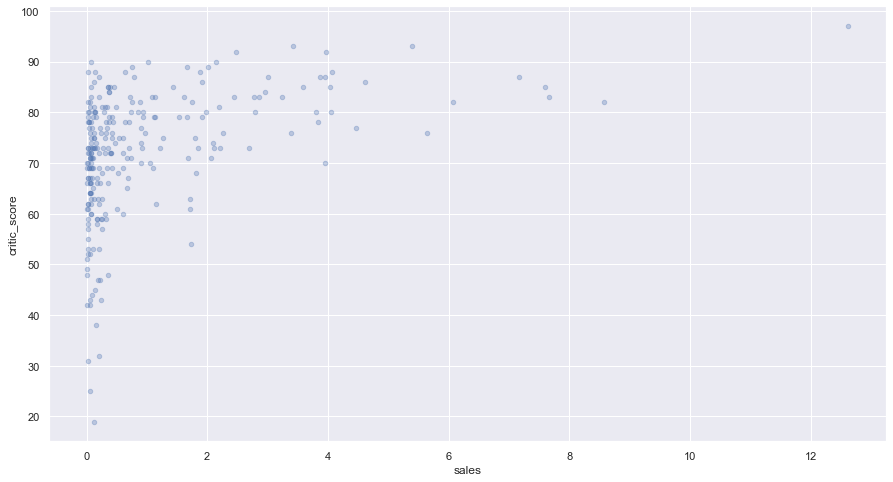

In [145]:
#Посмотрим диаграмму рассеяния зависимости кол-ва продаж от отзывов критиков для таблицы df_PS4_c
df_PS4_c.plot(x='sales', y='critic_score', kind='scatter', alpha=0.3,grid=True);

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


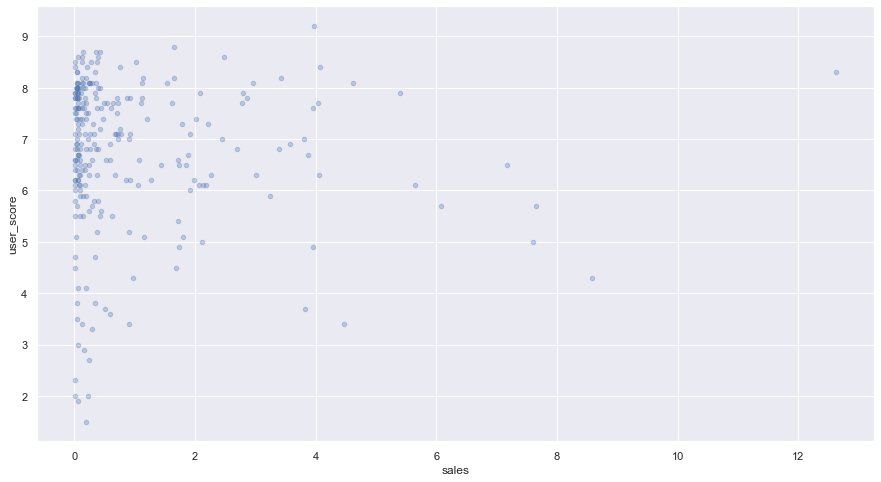

In [146]:
#Посмотрим диаграмму рассеяния зависимости кол-ва продаж от отзывов пользователей для таблицы df_PS4_c
df_PS4_c.plot(x='sales', y='user_score', kind='scatter', alpha=0.3,grid=True);

In [147]:
# корреляция для данных в таблице df_PS4_c
df_PS4_c.corr()

,year_of_release,sales,critic_score,user_score
year_of_release,1.000000,-0.235032,-0.021142,0.152447
sales,-0.235032,1.000000,0.406568,-0.031957
critic_score,-0.021142,0.406568,1.000000,0.557654
user_score,0.152447,-0.031957,0.557654,1.000000


По таблице корреляции видно, что есть слабая положительная корреляция (меньше 0,5) между кол-ом продаж и оценкой критиков: 0,4.
Корреляция между кол-ом продаж и оценками пользователей - отсутствует: -0,03.

Мы ожидали высокую корреляцию зависимости кол-ва продаж от оценок. Однако, из проведенного анализа видно, что корреляция слабая, а в случае с оценкой пользователей даже отсутствует. 

Однако, из диаграмм распределения видно, что у игр с большими продажами высокие оценки (пользователей и критиков). 

Проверим корреляцию для других выбранных платформ

In [148]:
list_platform = ['PS4', 'XOne', 'WiiU', 'PC']
for i in list_platform:
    df_x = df[(df['platform'] == i) & (df['year_of_release'] >= 2013)]
    corr_critic = df_x['sales'].corr(df_x['critic_score'])
    corr_user = df_x['sales'].corr(df_x['user_score'])
    print(f'Количество данных для платформы {i}: {len(df_x)}')
    print(f'Корреляция кол-ва продаж для платформы {i} от оценки критиков {corr_critic:.2f}')
    print(f'Корреляция кол-ва продаж для платформы {i} от оценки пользователей {corr_user:.2f}')
    print('---'*25)

Количество данных для платформы PS4: 392
Корреляция кол-ва продаж для платформы PS4 от оценки критиков 0.41
Корреляция кол-ва продаж для платформы PS4 от оценки пользователей -0.03
---------------------------------------------------------------------------
Количество данных для платформы XOne: 247
Корреляция кол-ва продаж для платформы XOne от оценки критиков 0.42
Корреляция кол-ва продаж для платформы XOne от оценки пользователей -0.07
---------------------------------------------------------------------------
Количество данных для платформы WiiU: 115
Корреляция кол-ва продаж для платформы WiiU от оценки критиков 0.38
Корреляция кол-ва продаж для платформы WiiU от оценки пользователей 0.42
---------------------------------------------------------------------------
Количество данных для платформы PC: 191
Корреляция кол-ва продаж для платформы PC от оценки критиков 0.20
Корреляция кол-ва продаж для платформы PC от оценки пользователей -0.09
----------------------------------------------

Видно, что корреляция кол-ва продаж от оценки критиков практически одинаковая для всех выбранных платформ - около 0.4. Однако, корреляция кол-ва продаж от оценки пользователей сильно отличается для платформы WiiU от других платформ. Только для этой платформы корреляция от оценки пльзователей выше, чем корреляция от оценки критиков и не отрицательная: 0,42 

#### 4. Посмотрим на общее распределение игр по жанрам

Посмотрим как распределены жанры игр по платформам

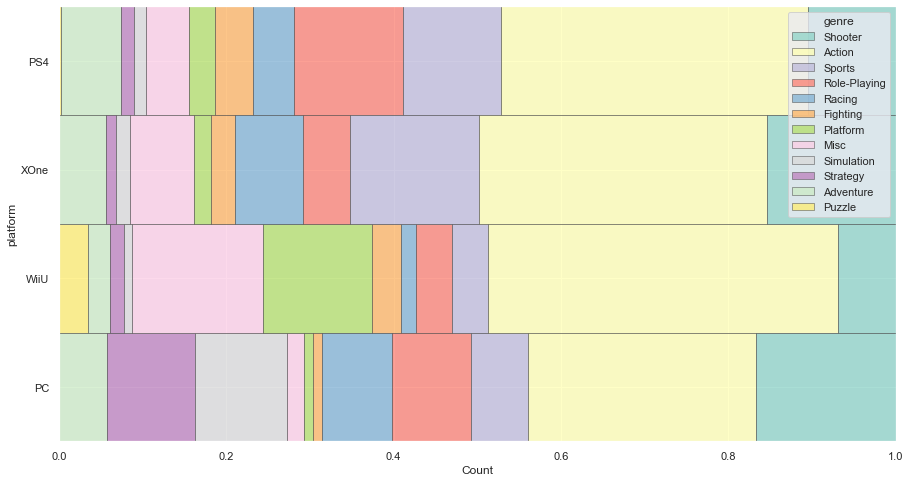

In [149]:
sns.histplot(
    df_set_platform.query('year_of_release>=2013'),
    y="platform", hue="genre",
    multiple="fill",
    palette=("Set3"),
    edgecolor=".3",
    linewidth=.5,
    log_scale=False,
);

Видно, что для всех платформ больше всего записей для жанрa Action (в процентном соотношении относительно кол-ва записей для платформы)

In [150]:
# Посмотрим медианное значение общих продаж для каждой платформы по жанрам
df_set_pl_g = df_set_platform.query('year_of_release>=2013').pivot_table(index='platform', values='sales', columns='genre',aggfunc='median')
df_set_pl_g 

genre,Action,Adventure,Fighting,Misc,Platform,Puzzle,Racing,Role-Playing,Shooter,Simulation,Sports,Strategy
platform,,,,,,,,,,,,
PC,0.065,0.03,0.05,0.020,0.035,NaN,0.030,0.09,0.210,0.10,0.060,0.105
PS4,0.155,0.07,0.17,0.075,0.300,0.02,0.230,0.20,0.970,0.21,0.525,0.080
WiiU,0.140,0.07,0.60,0.190,0.580,0.06,3.680,0.41,0.115,0.20,0.440,0.610
XOne,0.150,0.06,0.20,0.180,0.160,NaN,0.185,0.32,1.095,0.16,0.335,0.170


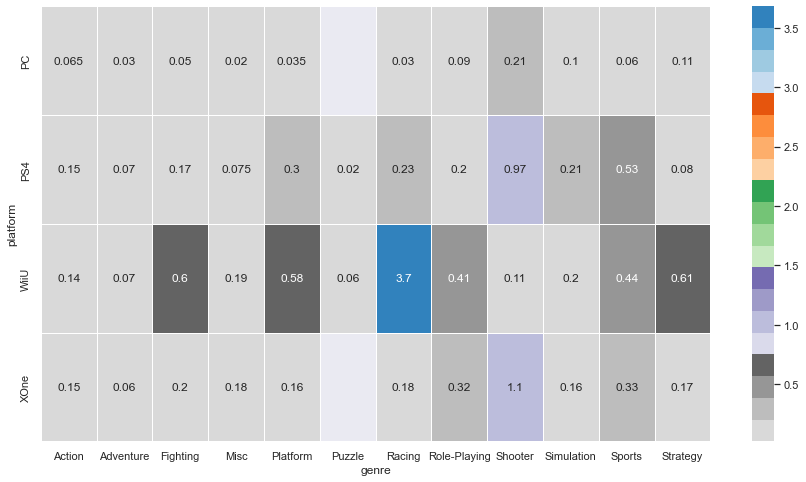

In [151]:
# Построим тепловую мартицу
sns.heatmap(df_set_pl_g, annot=True, linewidths=.5, cmap="tab20c_r");

* Несмотря на то, что жанр Action самый распространненый, медианное значение кол-ва продаж для этого жанра не самое высокое - ниже 200 тыс. копий по всем платформам.
* Жанр Shooter прибыльный для двух платформ - PS4 (чуть ниже 1 млн. копий продаж) и XOne (чуть больше 1 млн. копий продаж)
* Жанр Sport тоже популярен, но кол-во продаж по нему чуть выше 500 тыс. копий только для одной платформы - PS4


* Медианное значение кол-ва продаж для платформе PS4 в зависимости от жанра не очень высокое - только для 2 жанров превышает 500 тыс копий (Shooter and Sprts).
* Медианное значение кол-ва продаж для платформе WiiU практически по всем жанрам выше медианного значения для платформы PS4. И для 4х жанров медианное значение выше 500 тыс. копий (Fighting, Platform, Racing, Strategy).
* Медианное значение кол-ва продаж для платформы XOne похоже на значения платформы PS4, но только для одного жанра медианное значение превышает 500 тыс. копий (Shooter), тогда как для платформы PS4 - таких 2 жанра.
* По всем жанрам платформы PC - медианное значение кол-ва продаж ниже 500 тыс копий. Только для жанра Shooter медианное значение чуть превышает 200 тыс. копий.

Посмотрим какое максимальное кол-во продаж было по каждой платформе и жанру

In [152]:
df_set_pl_g_max = df_set_platform.query('year_of_release>=2013').pivot_table(index='platform', values='sales', columns='genre',aggfunc='max')
df_set_pl_g_max

genre,Action,Adventure,Fighting,Misc,Platform,Puzzle,Racing,Role-Playing,Shooter,Simulation,Sports,Strategy
platform,,,,,,,,,,,,
PC,1.17,0.12,0.05,0.66,0.06,NaN,0.25,1.28,1.36,3.05,0.63,1.67
PS4,12.62,1.66,2.78,4.32,1.91,0.02,2.42,7.17,14.63,0.42,8.58,0.22
WiiU,1.80,0.09,4.87,1.75,4.32,1.19,7.09,0.84,4.44,0.20,0.84,1.12
XOne,5.47,1.38,1.38,2.76,0.34,NaN,2.20,4.22,7.39,0.36,3.25,0.21


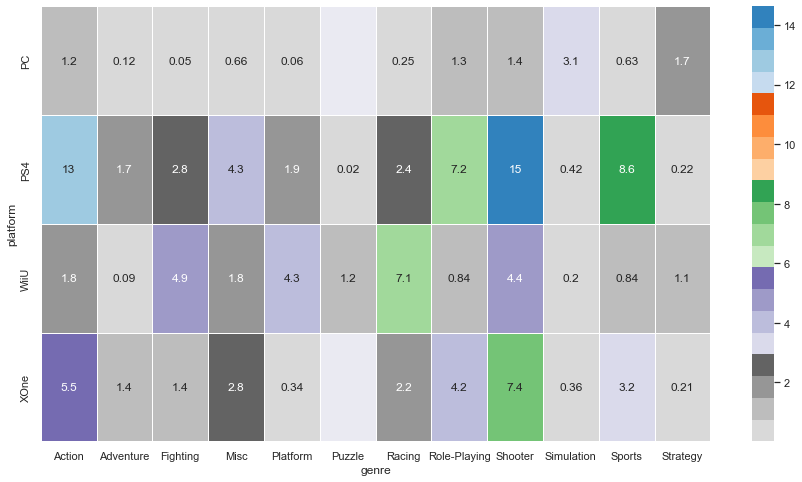

In [153]:
# Построим тепловую мартицу
sns.heatmap(df_set_pl_g_max, annot=True, linewidths=.5, cmap="tab20c_r");

Если сравнивать максимальные значения продаж, то видно, что жанр Action является популярным - большое кол-во продаж по двум платформам PS4 and XOne

Посмотрим по каким платформам и жанрам медианное значение кол-ва продаж выше 500 тыс. копий

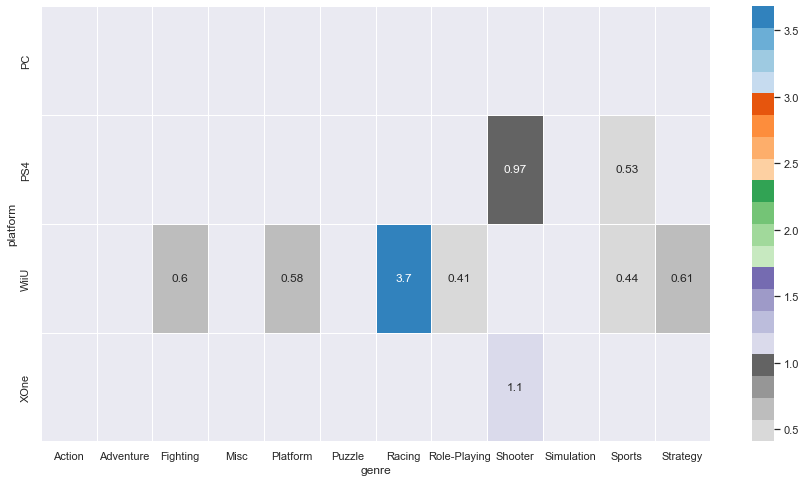

In [154]:
# Построим тепловую мартицу
sns.heatmap(df_set_pl_g [df_set_pl_g>0.4], annot=True, linewidths=.5, cmap="tab20c_r");

Посмотрим по каким пралформам и жанрам максимальное кол-во продаж выше 5 млн. копий

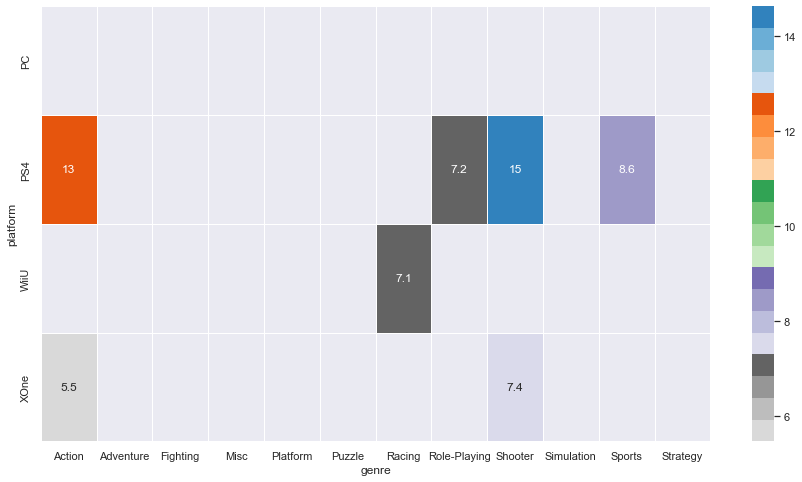

In [155]:
# Построим тепловую мартицу
sns.heatmap(df_set_pl_g_max[df_set_pl_g_max>=5], annot=True, linewidths=.5, cmap="tab20c_r");

Сравнивая медианные и максимальные значения продаж, можно сделать вывод, что самыми популярными и прибыльными жанрами являются жанры
Action, Shooter, Sport. Для платформы WiiU - жанр Racing. 

К не популярным и прибыльным можно отнести жанры Puzzle и Adventure 

## Составим портрет пользователя каждого региона (NA, EU, JP)

Создадим таблицу с суммой прадаж по регионам и платформам (за период 2013-2016 годы)

In [156]:
df_reg_sum = df.query('year_of_release>=2013').pivot_table(index='platform', aggfunc={'na_sales': sum, 'eu_sales': sum, 'jp_sales': sum, 'sales': sum})
df_reg_sum 

,eu_sales,jp_sales,na_sales,sales
platform,,,,
3DS,30.96,67.81,38.20,143.25
DS,0.85,0.00,0.57,1.54
PC,25.59,0.00,11.13,39.71
PS3,67.81,23.35,63.50,181.43
PS4,141.09,15.96,108.74,314.14
PSP,0.17,3.53,0.00,3.74
PSV,6.10,18.59,5.04,32.99
Wii,5.93,0.05,6.56,13.66
WiiU,19.85,10.88,29.21,64.63


##### Посмотрим 5 популярных платформ для регионов NA, EU и JP

Посмотрим 5 популярных платформ для региона NA

In [157]:
df_na_plt = df_reg_sum.loc[:, ['na_sales', 'sales']].sort_values(by='na_sales',ascending=False).head(5)
df_na_plt.reset_index(drop=False, inplace=True)
df_na_plt

,platform,na_sales,sales
0,PS4,108.74,314.14
1,XOne,93.12,159.32
2,X360,81.66,136.80
3,PS3,63.50,181.43
4,3DS,38.20,143.25


In [158]:
#добавим колонку с отношением продаж в NA к общим продажам
df_na_plt['ratio_na_pop'] = df_na_plt['na_sales']/df_na_plt['sales']

In [159]:
df_na_plt

,platform,na_sales,sales,ratio_na_pop
0,PS4,108.74,314.14,0.346151
1,XOne,93.12,159.32,0.584484
2,X360,81.66,136.80,0.596930
3,PS3,63.50,181.43,0.349997
4,3DS,38.20,143.25,0.266667


Видно, что для самой популярной платформы - процент продаж в NA только 34%. Это говори о том, что эта платформа популярна не только в NA. По платформам XOne and X360 - процент продаж в NA около 60% - это говорит о том, что эти платформы наиболее популярны в NA. Последние платформы - PS3 and 3DS -популярны не только в NA, но и в других регионах 

Посмотрим 5 популярных платформ для региона EU

In [160]:
df_eu_plt = df_reg_sum.loc[:, ['eu_sales', 'sales']].sort_values(by='eu_sales',ascending=False).head(5)
df_eu_plt.reset_index(drop=False, inplace=True)
df_eu_plt

,platform,eu_sales,sales
0,PS4,141.09,314.14
1,PS3,67.81,181.43
2,XOne,51.59,159.32
3,X360,42.52,136.80
4,3DS,30.96,143.25


In [161]:
#добавим колонку с отношением продаж в EU к общим продажам
df_eu_plt['ratio_eu_pop'] = df_eu_plt['eu_sales']/df_eu_plt['sales']

In [162]:
df_eu_plt

,platform,eu_sales,sales,ratio_eu_pop
0,PS4,141.09,314.14,0.449131
1,PS3,67.81,181.43,0.373753
2,XOne,51.59,159.32,0.323814
3,X360,42.52,136.80,0.310819
4,3DS,30.96,143.25,0.216126


По данным из таблице выше можно сделать вывод, что нет такой платформы, которая популярна в основном только в EU. Здесь те же самые платформы что и в регионе NA

Посмотрим 5 популярных платформ для региона JP

In [163]:
df_jp_plt = df_reg_sum.loc[:, ['jp_sales', 'sales']].sort_values(by='jp_sales',ascending=False).head(5)
df_jp_plt.reset_index(drop=False, inplace=True)
df_jp_plt

,platform,jp_sales,sales
0,3DS,67.81,143.25
1,PS3,23.35,181.43
2,PSV,18.59,32.99
3,PS4,15.96,314.14
4,WiiU,10.88,64.63


In [164]:
#добавим колонку с отношением продаж в JP к общим продажам
df_jp_plt['ratio_jp_pop'] = df_jp_plt['jp_sales']/df_jp_plt['sales']

In [165]:
df_jp_plt

,platform,jp_sales,sales,ratio_jp_pop
0,3DS,67.81,143.25,0.473368
1,PS3,23.35,181.43,0.128700
2,PSV,18.59,32.99,0.563504
3,PS4,15.96,314.14,0.050805
4,WiiU,10.88,64.63,0.168343


Из данных в таблице выше можно сделать вывод, что есть платформа, которая популярна в JP больше, чем в других регионах - PSV

In [166]:
# Создадим единую таблицу с процентами продаж по регионам и платформам.
# удалим столбцы с кол-ом продаж по регионам
df_na_x = df_na_plt.loc[:,['platform', 'ratio_na_pop']]
df_eu_x = df_eu_plt.loc[:,['platform', 'ratio_eu_pop']]
df_jp_x = df_jp_plt.loc[:,['platform', 'ratio_jp_pop']]

In [167]:
# объеденим две таблицы (NA and EU)
merged = pd.merge(df_na_x,df_eu_x,on=['platform'], how='outer')

In [168]:
merged

,platform,ratio_na_pop,ratio_eu_pop
0,PS4,0.346151,0.449131
1,XOne,0.584484,0.323814
2,X360,0.596930,0.310819
3,PS3,0.349997,0.373753
4,3DS,0.266667,0.216126


In [169]:
# объеденим таблицу merged с данным для JP
merged = pd.merge(merged,df_jp_x,on=['platform'], how='outer')

In [170]:
merged

,platform,ratio_na_pop,ratio_eu_pop,ratio_jp_pop
0,PS4,0.346151,0.449131,0.050805
1,XOne,0.584484,0.323814,NaN
2,X360,0.596930,0.310819,NaN
3,PS3,0.349997,0.373753,0.128700
4,3DS,0.266667,0.216126,0.473368
5,PSV,NaN,NaN,0.563504
6,WiiU,NaN,NaN,0.168343


In [171]:
# замена индексов колонкой platform
merged.set_index('platform', inplace=True)

In [172]:
merged

,ratio_na_pop,ratio_eu_pop,ratio_jp_pop
platform,,,
PS4,0.346151,0.449131,0.050805
XOne,0.584484,0.323814,NaN
X360,0.596930,0.310819,NaN
PS3,0.349997,0.373753,0.128700
3DS,0.266667,0.216126,0.473368
PSV,NaN,NaN,0.563504
WiiU,NaN,NaN,0.168343


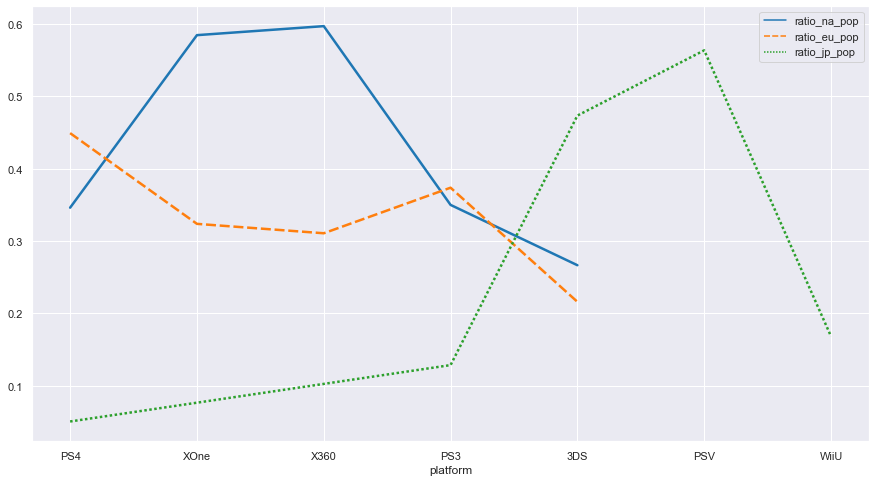

In [173]:
# Построим график
sns.set(rc = {'figure.figsize':(15,8)})
sns.lineplot(data=merged, palette="tab10", linewidth=2.5);

* Из графика видно, что платформы PS3 и PS4 практичеки одинаково популярна в EU и NA, но в EU они более популярны. В Японии эти платформы не очень популярны.
* Платформы XOne and X360 наиболее популярны в NA, чем в других регионах.
* Платформы 3DS, WiiU и PSV наиболее популярны в PJ

##### Посмотрим 5 популярных жанров для регионов NA, EU и JP

Создадим таблицу с суммой прадаж по регионам и жанрам (за период 2013-2016 годы)

In [174]:
df_reg_g_sum = df.query('year_of_release>=2013').pivot_table(index='genre', aggfunc={'na_sales': sum, 'eu_sales': sum, 'jp_sales': sum, 'sales': sum})
df_reg_g_sum

,eu_sales,jp_sales,na_sales,sales
genre,,,,
Action,118.36,40.49,126.07,322.15
Adventure,8.25,5.82,7.14,23.64
Fighting,8.55,7.65,15.55,35.31
Misc,20.04,9.44,27.49,63.06
Platform,15.58,4.79,18.14,42.63
Puzzle,1.00,1.18,0.83,3.17
Racing,20.19,2.30,12.96,39.89
Role-Playing,36.97,51.04,46.40,145.89
Shooter,87.86,6.61,109.74,232.98


Посмотрим 5 популярных жанров для региона NA

In [175]:
df_na_gnr = df_reg_g_sum.loc[:, ['na_sales', 'sales']].sort_values(by='na_sales',ascending=False).head(5)
df_na_gnr.reset_index(drop=False, inplace=True)
df_na_gnr

,genre,na_sales,sales
0,Action,126.07,322.15
1,Shooter,109.74,232.98
2,Sports,65.27,150.65
3,Role-Playing,46.40,145.89
4,Misc,27.49,63.06


In [176]:
#добавим колонку с отношением продаж в NA к общим продажам
df_na_gnr['ratio_na_pop'] = df_na_gnr['na_sales']/df_na_gnr['sales']

In [177]:
df_na_gnr

,genre,na_sales,sales,ratio_na_pop
0,Action,126.07,322.15,0.391339
1,Shooter,109.74,232.98,0.471028
2,Sports,65.27,150.65,0.433256
3,Role-Playing,46.40,145.89,0.318048
4,Misc,27.49,63.06,0.435934


Посмотрим 5 популярных жанров для региона EU

In [178]:
df_eu_gnr = df_reg_g_sum.loc[:, ['eu_sales', 'sales']].sort_values(by='eu_sales',ascending=False).head(5)
df_eu_gnr.reset_index(drop=False, inplace=True)
df_eu_gnr

,genre,eu_sales,sales
0,Action,118.36,322.15
1,Shooter,87.86,232.98
2,Sports,60.52,150.65
3,Role-Playing,36.97,145.89
4,Racing,20.19,39.89


In [179]:
#добавим колонку с отношением продаж в EU к общим продажам
df_eu_gnr['ratio_eu_pop'] = df_eu_gnr['eu_sales']/df_eu_gnr['sales']

In [180]:
df_eu_gnr

,genre,eu_sales,sales,ratio_eu_pop
0,Action,118.36,322.15,0.367406
1,Shooter,87.86,232.98,0.377114
2,Sports,60.52,150.65,0.401726
3,Role-Playing,36.97,145.89,0.253410
4,Racing,20.19,39.89,0.506142


Посмотрим 5 популярных жанров для региона JP

In [181]:
df_jp_gnr = df_reg_g_sum.loc[:, ['jp_sales', 'sales']].sort_values(by='jp_sales',ascending=False).head(5)
df_jp_gnr.reset_index(drop=False, inplace=True)
df_jp_gnr

,genre,jp_sales,sales
0,Role-Playing,51.04,145.89
1,Action,40.49,322.15
2,Misc,9.44,63.06
3,Fighting,7.65,35.31
4,Shooter,6.61,232.98


In [182]:
#добавим колонку с отношением продаж в JP к общим продажам
df_jp_gnr['ratio_jp_pop'] = df_jp_gnr['jp_sales']/df_jp_gnr['sales']

In [183]:
df_jp_gnr

,genre,jp_sales,sales,ratio_jp_pop
0,Role-Playing,51.04,145.89,0.349853
1,Action,40.49,322.15,0.125687
2,Misc,9.44,63.06,0.149699
3,Fighting,7.65,35.31,0.216653
4,Shooter,6.61,232.98,0.028372


In [184]:
# Создадим единую таблицу с процентами продаж по регионам и жанрам.
# удалим столбцы с кол-ом продаж по регионам
df_na_x = df_na_gnr.loc[:,['genre', 'ratio_na_pop']]
df_eu_x = df_eu_gnr.loc[:,['genre', 'ratio_eu_pop']]
df_jp_x = df_jp_gnr.loc[:,['genre', 'ratio_jp_pop']]

In [185]:
# объеденим 3 таблицы (NA , EU, JP)
merged_gnr = pd.merge(pd.merge(df_na_x,df_eu_x,on='genre',how='outer'),df_jp_x,on='genre', how='outer')

In [186]:
merged_gnr

,genre,ratio_na_pop,ratio_eu_pop,ratio_jp_pop
0,Action,0.391339,0.367406,0.125687
1,Shooter,0.471028,0.377114,0.028372
2,Sports,0.433256,0.401726,NaN
3,Role-Playing,0.318048,0.253410,0.349853
4,Misc,0.435934,NaN,0.149699
5,Racing,NaN,0.506142,NaN
6,Fighting,NaN,NaN,0.216653


In [187]:
# замена индексов колонкой genre
merged_gnr.set_index('genre', inplace=True)

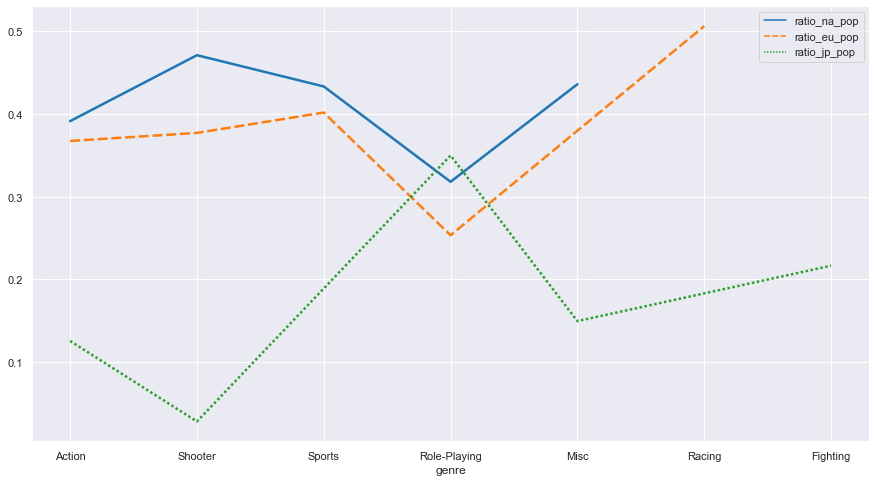

In [188]:
# Построим график
sns.set(rc = {'figure.figsize':(15,8)})
sns.lineplot(data=merged_gnr, palette="tab10", linewidth=2.5);

По графику видно, что 4 самых популярных жанра из 5 в регионах NA и EU совпадают:  
* 1. Action
* 2. Shooter
* 3. Sports
* 4. Role-Playing
* 5. Misc (для NA), Racing (для EU)

Для региона JP популярны жанры отличаются от популярных в NA и EU:
* 1. Role-Playing
* 2. Action
* 3. Misc
* 4. Fighting
* 5. Shooter

По кол-ву проданных копий можно сделать вывод, что жанр Action самый популярный в регионах NA и EU. Чуть менее популярен жанр Shooter. Жанры, которые занимают 5 место по популярности в NA и EU отличаются. Для обоих регионов кол-во проданных копий для самого популярного жанра отличается от жанра на 5 месте примерно в 5 раз. 

Для региона JP самым популярныем жанром является жанр Role-Playing. Второе место занимает жанр Action. Последнее место занимает жанр, который занимает 2е место для NA и EU - Shooter. И здесь разница по проданным копиям между первым местом и последним значетельно выше, чем эта разница в NA и EU. Кол-во проданных копий для региона JP для жанра Shooter (последнее место) в 10 раз ниже, чем кол-во проданных копий жанра Role-Playing (первое место). Это говорит о том, что жанр Role-Playing в JP значительно более популярен, чем жанры, коротые расположены на 3- 5 местах.   

Посмотрим влияет ли рейтинг ESRB на продажи в отдельном регионе

In [189]:
# Cумма количества продаж в регионе NA по категориям ESRB
na_rating = df.groupby('rating')[['na_sales']].sum()
na_rating.sort_values('na_sales', ascending=False).style.bar(color='red')

,na_sales
rating,
E,1289.620000
T,751.200000
M,746.130000
E10+,352.560000
EC,1.530000
AO,1.260000
RP,0.000000


In [190]:
# Cумма количества продаж в регионе EU по категориям ESRB
eu_rating = df.groupby('rating')[['eu_sales']].sum()
eu_rating.sort_values('eu_sales', ascending=False).style.bar(color='green')

,eu_sales
rating,
E,709.190000
M,482.540000
T,423.550000
E10+,187.860000
AO,0.610000
EC,0.110000
RP,0.040000


In [191]:
# Cумма количества продаж в регионе JP по категориям ESRB
jp_rating = df.groupby('rating')[['jp_sales']].sum()
jp_rating.sort_values('jp_sales', ascending=False).style.bar(color='cyan')

,jp_sales
rating,
E,199.480000
T,150.880000
M,63.610000
E10+,40.200000
AO,0.000000
EC,0.000000
RP,0.000000


* По всем регионам на первом месте стоит категория "E" (подходит всем возрастам).
* На втором месте для регионов NA и JP стоит категория "T" (подходит для пользователй старше 13 и старше). Для региона EU на втором месте стоит категория "M" (подходит для пользователй старше 17 и старше)
* На третьем месте для регионов NA и JP стоит категория "M" (подходит для пользователй старше 17 и старше). Для региона EU на третьем месте стоит категория "T" (подходит для пользователй старше 13 и старше). 
* На четвертом месте стоит одинаковая категория для всех регионов "E+10" (подходит для пользователй старше 10 и старше) 

##### Выводы: 
* Для региононв NA и EU самой популярной платформой является платформа PS4, самый популярный жанр - Action и самая популярная возрастная категория - Е.
* Для региона JP самой популярной платформой является платформа 3DS, самый популярный жанр - Role-Playing и самая популярная возрастная категория - Е.

## Проверка гипотез

#### Гипотеза 1. Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Оценим отличается ли средние пользовательские рейтинги платформ XOne и PC для периода с 2013 по 2016 год.

In [192]:
# Создадим таблицу для периода 2013-2016 годов
df_usr_score = df.query('year_of_release>=2013 and user_score_if=="Y"')

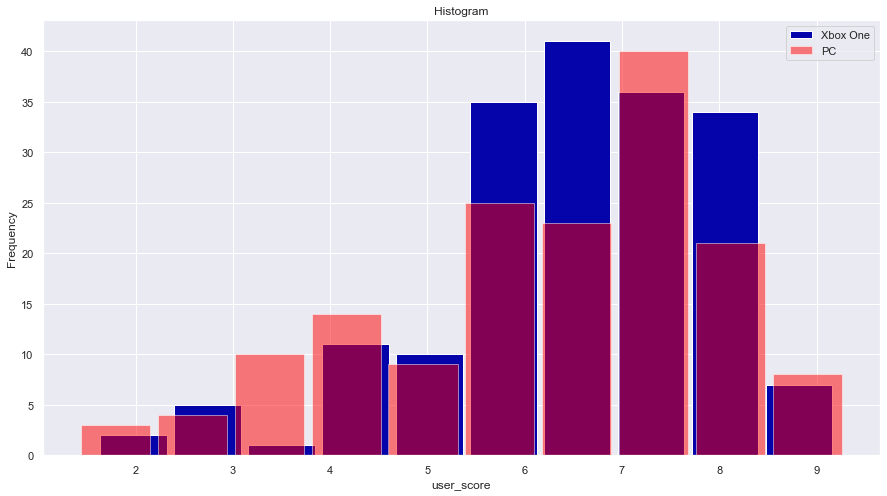

In [193]:
# Построим гистограмму для пользовательской оценки для 2х платформ
df_usr_score[df_usr_score['platform']=='XOne']['user_score'].plot.hist(grid=True, rwidth=0.9, color='#0504aa')
df_usr_score[df_usr_score['platform']=='PC']['user_score'].plot.hist(grid=True, rwidth=0.9, color='red',alpha=0.5)
plt.title('Histogram')
plt.xlabel('user_score')
plt.ylabel('Frequency')
plt.legend(labels=('Xbox One','PC'));

Распределение для платформы Xbox One и PC выглядят как распределения с отрицательной асимметрией. 

Сделаем проверку для определения являются ли эти распределения нормальными.

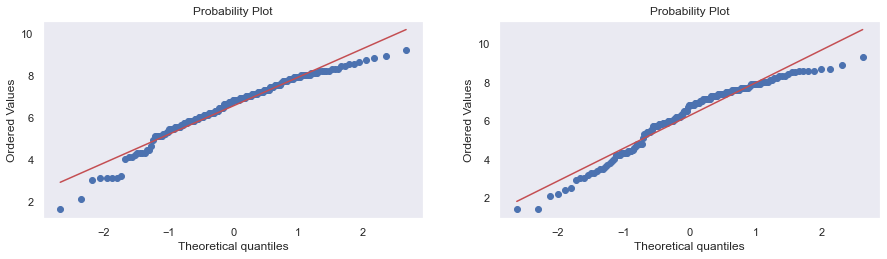

In [194]:
#График квантилей для оценки пользователей платформы XOne
measurements_x = df_usr_score[df_usr_score['platform']=='XOne']['user_score']
measurements_p = df_usr_score[df_usr_score['platform']=='PC']['user_score']

ax1 = plt.subplot(221)
st.probplot(measurements_x, dist="norm", plot=ax1)
plt.grid()
ax2 = plt.subplot(222)
st.probplot(measurements_p, dist="norm", plot=ax2)
plt.grid()
plt.show()

Вывод: значения не сильно отклоняются от теоретической линии, следовательно, данные распределены по нормальному закону

Проверим с помощью t-теста отличается ли средние пользовательские рейтинги платформ XOne и PC для периода с 2013 по 2016 год.

Мы имеем две независимые выборки (данные по оценкам пользователей по 2м платформам). Примем, что средний пользовательский рейтинг не отличается - нулевая гипотиза. Альтернативная гипотиза - средний пользовательский рейтинг отличается. Если мы сможем опровергнуть нулевую гипотизу, то средний пользовательский рейтинг отличается. Посчитаем T-критерий для средних значений двух независимых выборок.

In [195]:
alpha = 0.05
usr_scr_xo = df_usr_score[df_usr_score['platform']=='XOne']['user_score']
usr_scr_pc = df_usr_score[df_usr_score['platform']=='PC']['user_score']
results = st.ttest_ind(
    usr_scr_xo, 
    usr_scr_pc)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.13235357785478058
Не получилось отвергнуть нулевую гипотезу


Вывод: Т.к не получилось отвергнуть нулевую гипотезу, то можно сделать вывод, что средний пользовательский рейтинг для платформ Xbox One и PC не отличается. 

#### Гипотеза 2. Средние пользовательские рейтинги жанров Action и Sports разные

Оценим отличается ли средние пользовательские рейтинги жанров Action и Sports для периода с 2013 по 2016 год.

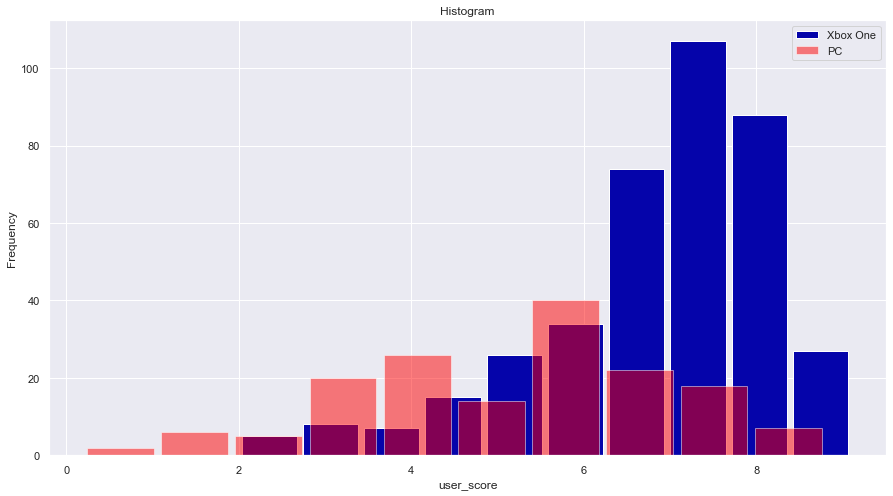

In [196]:
# Построим гистограмму для пользовательской оценки для 2х жанров
df_usr_score[df_usr_score['genre']=='Action']['user_score'].plot.hist(grid=True, rwidth=0.9, color='#0504aa')
df_usr_score[df_usr_score['genre']=='Sports']['user_score'].plot.hist(grid=True, rwidth=0.9, color='red',alpha=0.5)
plt.title('Histogram')
plt.xlabel('user_score')
plt.ylabel('Frequency')
plt.legend(labels=('Xbox One','PC'));

Распределение для жанров Action и Sports выглядят как распределения с отрицательной асимметрией.

Сделаем проверку для определения являются ли эти распределения нормальными.

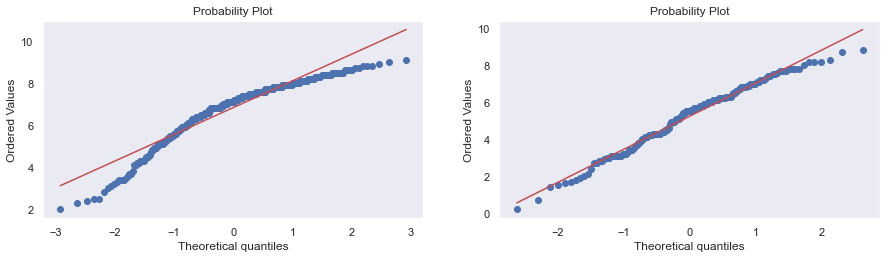

In [197]:
#График квантилей для оценки пользователей платформы XOne
measurements_a = df_usr_score[df_usr_score['genre']=='Action']['user_score']
measurements_s = df_usr_score[df_usr_score['genre']=='Sports']['user_score']

ax1 = plt.subplot(221)
st.probplot(measurements_a, dist="norm", plot=ax1)
plt.grid()
ax2 = plt.subplot(222)
st.probplot(measurements_s, dist="norm", plot=ax2)
plt.grid()
plt.show()

Вывод: значения не сильно отклоняются от теоретической линии, следовательно, данные распределены по нормальному закону

Проверим с помощью t-теста отличается ли средние пользовательские рейтинги для жанров Action и Sports для периода с 2013 по 2016 год.

Мы имеем две независимые выборки (данные по оценкам пользователей по 2м жанрам). Примем, что средний пользовательский рейтинг не отличается - нулевая гипотиза. Альтернативная гипотиза - средний пользовательский рейтинг отличается. Если мы сможем опровергнуть нулевую гипотизу, то средний пользовательский рейтинг отличается. Посчитаем T-критерий для средних значений двух независимых выборок.

In [198]:
alpha = 0.05
usr_scr_xo = df_usr_score[df_usr_score['genre']=='Action']['user_score']
usr_scr_pc = df_usr_score[df_usr_score['genre']=='Sports']['user_score']
results = st.ttest_ind(
    usr_scr_xo, 
    usr_scr_pc)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.108736726777725e-27
Отвергаем нулевую гипотезу


Вывод: Т.к получилось отвергнуть нулевую гипотезу, то можно сделать вывод, что средний пользовательский рейтинг для жанров Action и Sports - отличается.

## Вывод:

Цель данного иследования была определить по историческим данным продажах игр определяющие успешность игры закономерности для планирования рекламных акций на 2017 год.

Анализ был сделан по таблице с 16 тыс. данными по играм, выпущенным с 1980 года по 2016 год. Данные включают в себя кол-во проданных копий по 4-м регионам - Северная Америка, Европа, Япония и данные для остальных регионов, объединенных в одну колонку.

Было определенно, что для планирования рекламных акций на 2017 необходимо рассматривать только данные начиная с 2013 года, т.к эти данные включают в себя актуальные игровые платформы.

Было выявленно, что для региона Северной Америки наиболее популярной игровой платформой является платформа PS4, чуть менее популярной платформой является Xbox One. Наиболее популярные жанры игр в этом регионе это Action и Shooter. Возрастная категория наиболее продаваемых игр - Е (для всех возрастов)

Для Европы наиболее популярной игровой платформой является платформа PS4, чуть менее популярной платформой является PS3. На третьем месте платформа - Xbox One. Наиболее популярные жанры игр в этом регионе такие же как и в Северной Америке: Action и Shooter. Возрастная категория наиболее продаваемых игр - Е (для всех возрастов)

Для Японии наиболее популярной игровой платформой является платформа 3DS. Менее популярная платформа PS3. Платформа Xbox One не вошла в топ5 для этого региона. Наиболее популярные жанры игр в этом регионе : Role-Playing. На втором месте жанр Action. Возрастная категория наиболее продаваемых игр - Е (для всех возрастов).

Таким образом, для планирования рекламных акций, можно выбрать платформы PS4 для Северной Америки и Европы, и 3DS для Японии. Жанр игр для Северной Америки и Европы - Action и Shooter. Для Японии - Role-Playing.